# SECOP II - Procesamiento de los datos
El presente notebook tiene como proposito entender y procesar los datos de contratación respectivos a SECOP II para las entidades de Bogotá. El producto final es una base de datos que pueda ser usada para detectar posibles irregularidades en los contratos mediante modelos posteriores.

In [1]:
import sys
print(sys.executable)
print(sys.getdefaultencoding())

c:\Users\prestamour\.conda\envs\vigia_art\python.exe
utf-8


In [2]:
#Requerimientos
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
import docx

%matplotlib inline
pd.plotting.register_matplotlib_converters()
pd.set_option('display.max_columns', None, 'display.max_colwidth', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
#pd.options.display.max_colwidth = 100

In [3]:
os.getcwd()

'd:\\vigia\\articulo\\vigia_datos'

## SECOP II - Procesos de contratación

Primera base de datos a inspeccionar, se encuentra con el mismo nombre en el portal de Datos Abiertos Colombia([enlace](https://www.datos.gov.co/Gastos-Gubernamentales/SECOP-II-Procesos-de-Contrataci-n/p6dx-8zbt)). Cada observación obedece a un proceso.

In [4]:
%%time

#Dirección para llegar a la carpeta, puede varias entre equipos.
path = 'secopII_rawdata\SECOP_II_-_Procesos_de_Contrataci_n.csv'

#Importar datos
secop2_procesos_de_contratacion = pd.read_csv(path)

c:\Users\prestamour\.conda\envs\vigia_art\lib\site-packages\decorator.py:232: DtypeWarning: Columns (15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  return caller(func, *(extras + args), **kw)


Wall time: 48.8 s


In [5]:
secop2_procesos_de_contratacion.shape

(803500, 57)

In [6]:
secop2_procesos_de_contratacion.columns

Index(['Entidad', 'Nit Entidad', 'Departamento Entidad', 'Ciudad Entidad',
       'OrdenEntidad', 'Entidad Centralizada', 'ID del Proceso',
       'Referencia del Proceso', 'PCI', 'ID del Portafolio',
       'Nombre del Procedimiento', 'Descripción del Procedimiento', 'Fase',
       'Fecha de Publicacion del Proceso', 'Fecha de Ultima Publicación',
       'Fecha de Publicacion (Fase Planeacion Precalificacion)',
       'Fecha de Publicacion (Fase Seleccion Precalificacion)',
       'Fecha de Publicacion (Manifestacion de Interes)',
       'Fecha de Publicacion (Fase Borrador)',
       'Fecha de Publicacion (Fase Seleccion)', 'Precio Base',
       'Modalidad de Contratacion', 'Justificación Modalidad de Contratación',
       'Duracion', 'Unidad de Duracion', 'Fecha de Recepcion de Respuestas',
       'Fecha de Apertura de Respuesta', 'Fecha de Apertura Efectiva',
       'Ciudad de la Unidad de Contratación',
       'Nombre de la Unidad de Contratación', 'Proveedores Invitados',
       '

Filtrando por ``Departamento Entidad = Distrito Capital de Bogotá ó No definido`` y ``OrdenEntidad = Territorial ó Corporación Autónoma`` 

In [7]:
%%time
#Realizar primer filtro acordado.
secop_21 = secop2_procesos_de_contratacion[
    ( (secop2_procesos_de_contratacion['Departamento Entidad'] == 'Distrito Capital de Bogotá') | 
     (secop2_procesos_de_contratacion['Departamento Entidad'] == 'No Definido') ) &
    ( (secop2_procesos_de_contratacion['OrdenEntidad'] == 'Territorial') | 
     (secop2_procesos_de_contratacion['OrdenEntidad'] == 'Corporación Autónoma'))]

del secop2_procesos_de_contratacion

Wall time: 606 ms


In [8]:
secop_21.shape

(242821, 57)

### Refinamiento de los filtros para Bogotá
Se procede a filtrar detalladamente las filas referentes a entidades de Bogotá. Se revisan las entidades tiniendo en cuenta el Orden de la entidad y departamento que registra, con esto se verifican los nombre de las entidades contenidas y se indagan aquellas que generan dudas. Con esto se marcan mediante una nueva variables aquellas entidades que no pertenecen a Bogotá, luego se eliminaran aquellas filas marcadas y la variable indicada.

Revisión de las corporaciones autónomas.

In [9]:
#Confirmar nombre de las entidades en mayúscula
secop_21['Entidad'] = secop_21['Entidad'].str.upper()

In [10]:
secop_21.loc[secop_21['OrdenEntidad'] == 'Corporación Autónoma', 'Entidad'].unique()

array(['CORPORACIÓN DE LA INDUSTRIA AERONÁUTICA COLOMBIANA S.A.',
       'EMPRESA INDUSTRIAL Y COMERCIAL DEL ESTADO LOTERIA DEL TOLIMA',
       'PERSONERIA DE BOGOTA',
       'COMISIÓN PARA EL ESCLARECIMIENTO DE LA VERDAD, LA CONVIVENCIA Y LA NO REPETICIÓN',
       'CORPORACION AUTONOMA REGIONAL DE NARIÑO',
       'E.S.E HOSPITAL LOCAL DE CANDELARIA VALLE',
       'CORPORACIÓN AUTÓNOMA REGIONAL DEL CESAR'], dtype=object)

Entidades con revisión:
- *CORPORACIÓN DE LA INDUSTRIA AERONÁUTICA COLOMBIANA S.A.*: Su mayor accionista es la República de Colombia y trabaja para la fuerza aérea. **Se expluye**.
- *'COMISIÓN PARA EL ESCLARECIMIENTO DE LA VERDAD, LA CONVIVENCIA Y LA NO REPETICIÓN*: "El Artículo 1° del Decreto 588 de 2017, establece la naturaleza de la Comisión como un ente autónomo e independiente del orden nacional ... con autonomía administrativa, presupuestal ...". **Se excluye**.
De las corporaciones autónomas solo permanece *PERSONERIA DE BOGOTA*.

In [11]:
#Columna que indicará si la observación se refiere a entidades fuera de Bogotá

#Se inicializa con todas las entidades siendo de Bogotá
secop_21['ENT_NO_BOGOTA'] = 0

#Se marcan entidades de corporación autónoma fuera de Bogotá
secop_21['ENT_NO_BOGOTA'] = 1*( (secop_21['OrdenEntidad']=='Corporación Autónoma') & 
                             (secop_21['Entidad']!='PERSONERIA DE BOGOTA') )

In [12]:
#Confirmación de las entidades fuera de Bogotá
secop_21[['OrdenEntidad', 'ENT_NO_BOGOTA']].value_counts()

OrdenEntidad          ENT_NO_BOGOTA
Territorial           0                236332
Corporación Autónoma  1                  4919
                      0                  1570
dtype: int64

Revisón de entidades territoriales con departamento "Distrito Capital de Bogotá". 

Se confirmará inicialmente que no se presenten entidades de la Gobernación de Cundinamarca o demás entidades nacionales y departamentales que son marcadas en la variable de entidades que no son de Bogotá

In [13]:
#Nombre de las entidades que contienen el nombre cundinamarca o referente a otros departamentos.
dep_pat = 'CUNDINAMARCA|GOBERNACI|DEPARTAMENTAL|NACIONAL|REGIONAL'

print('Observaciones de Entidades referentes a la Gobernación de Cundinamarca u otros departamentos')
print( secop_21['Entidad'].str.contains(dep_pat, regex=True).value_counts() )

secop_21.loc[secop_21['Entidad'].str.contains(dep_pat, regex=True), 'ENT_NO_BOGOTA'] = 1

Observaciones de Entidades referentes a la Gobernación de Cundinamarca u otros departamentos
False    220688
True      22133
Name: Entidad, dtype: int64


In [14]:
secop_21[['Departamento Entidad', 'ENT_NO_BOGOTA']].value_counts().sort_index()

Departamento Entidad        ENT_NO_BOGOTA
Distrito Capital de Bogotá  0                 55724
                            1                 11729
No Definido                 0                160084
                            1                 15284
dtype: int64

Revisión de entidades excluidas en el proceso previo.

In [15]:
#Excluidas
# secop_21.loc[(secop_21['Departamento Entidad']=='Distrito Capital de Bogotá') & 
#              (secop_21['ENT_NO_BOGOTA']==1), 'Entidad'].unique()

#Entidades de departamento Distrito Capital que no fueron excluidas por ser departamentales
secop_21.loc[(secop_21['Departamento Entidad']=='Distrito Capital de Bogotá') & 
             (secop_21['ENT_NO_BOGOTA']==0), 'Entidad'].unique()

array(['EMPRESA DE TRANSPORTE DEL TERCER MILENIO TRANSMILENIO S. A.',
       'SECRETARIA DE EDUCACION DEL DISTRITO', 'ALCALDIA LOCAL DE BOSA',
       'SECRETARIA DISTRITAL DE AMBIENTE', 'CONTRALORIA DE BOGOTA',
       'ENTIDAD DE GESTION ADMINISTRATIVA Y TECNICA',
       'ALCALDIA LOCAL DE SAN CRISTOBAL',
       'SECRETARIA DISTRITAL DEL HABITAT', 'ALCALDIA LOCAL DE SUBA',
       'INSTITUTO PARA LA INVESTIGACIÓN EDUCATIVA Y EL DESARROLLO PEDAGÓGICO - IDEP',
       'INSTITUTO DISTRITAL DE PATRIMONIO CULTURAL',
       'INSTITUTO DE DESARROLLO URBANO', 'CAJA DE LA VIVIENDA POPULAR',
       'INSTITUTO DISTRITAL DE PROTECCION Y BIENESTAR ANIMAL',
       'CENTRAL ADMINISTRATIVA Y CONTABLE CENAC PERSONAL',
       'ALCALDIA MUNICIPAL PARATEBUENO', 'ALCALDIA LOCAL DE KENNEDY',
       'ALCALDIA LOCAL DE TUNJUELITO',
       'ALCALDIA LOCAL DE SANTAFE- FONDO DE DESARROLLO LOCAL DE SANTA FE',
       'ALCALDIA MUNICIPAL DEL COROZAL', 'METRO DE BOGOTA SA',
       'UNIDAD ADMINISTRATIVA ESPECIAL DE RE

Al igual que las entidades nacionales y departamentales se excluyen entidades correspondientes a municipios diferentes de Bogotá detectados en la revisión de entidades.

In [16]:
#Determinar entidades de alcaldias municipales y demás externas a Bogotá
mun_pat = 'MUNICIPAL|MUNICIPIO|GACHETA|CHAPARRAL|SONSON'
ent_exc = ['RENTING DE ANTIOQUIA', 'EMPRESA DISTRIBUIDORA DEL PACIFICO S.A. E.S.P',  #Entidades particulares a excluir
           'ASOCIACION AEROPUERTO DEL CAFE', 'EMPRESA SOCIAL DEL ESTADO HOSPITAL JOSE CAYETANO VASQUEZ DE PUERTO BOYACA',
           'HOSPITAL ISMAEL ROLDAN VALENCIA']

print('Observaciones de Entidades referentes a diversos municipios')
print( secop_21['Entidad'].str.contains(mun_pat, regex=True).value_counts() )

secop_21.loc[secop_21['Entidad'].str.contains(mun_pat, regex=True), 'ENT_NO_BOGOTA'] = 1
secop_21.loc[secop_21['Entidad'].isin(ent_exc), 'ENT_NO_BOGOTA'] = 1

Observaciones de Entidades referentes a diversos municipios
False    218137
True      24684
Name: Entidad, dtype: int64


In [17]:
secop_21[['Departamento Entidad', 'ENT_NO_BOGOTA']].value_counts().sort_index()

Departamento Entidad        ENT_NO_BOGOTA
Distrito Capital de Bogotá  0                 54408
                            1                 13045
No Definido                 0                136245
                            1                 39123
dtype: int64

Revisón de entidades territoriales con departamento "No Definido". Hay una cantidad considerable de departamento "No Definido" por lo cual se incluyen y se realiza la respectiva revisión de las entidades.

In [18]:
#Entidades con departamento no definido que no fueron excluidas previamente.
secop_21.loc[(secop_21['Departamento Entidad']=='No Definido') & 
             (secop_21['ENT_NO_BOGOTA']==0), 'Entidad'].unique()

array(['SECRETARÍA GENERAL DE LA ALCALDÍA MAYOR DE BOGOTÁ',
       'SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E.',
       'ESE HOSPITAL SAN RAFAEL DE FUSAGASUGÁ',
       'EMPRESA DE ACUEDUCTO Y ALCANTARILLADO DE BOGOTÁ - E.S.P.',
       'SUBRED INTEGRADA DE SERVICIOS DE SALUD CENTRO ORIENTE E.S.E',
       'UNIDAD ADMINISTRATIVA ESPECIAL DE SERVICIOS PÚBLICOS',
       'INSTITUTO DISTRITAL DE LAS ARTES',
       'UNIDAD ADMINISTRATIVA ESPECIAL CUERPO OFICIAL DE BOMBEROS DE BOGOTA',
       'FONDO FINANCIERO DISTRITAL DE SALUD..',
       'SECRETARÍA DISTRITAL DE MOVILIDAD',
       'SECRETARIA DISTRITAL DE INTEGRACIÓN SOCIAL...',
       'DISTRITO ESPECIAL INDUSTRIAL Y PORTUARIO DE BARRANQUILLA',
       'SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCCIDENTE ESE.',
       'ALCALDIA LOCAL DE FONTIBON', 'SECRETARIA DISTRITAL DE LA MUJER',
       'EMPRESAS PUBLICAS DEL QUINDIO SA ESP',
       'INSTITUTO DISTRITAL PARA LA PROTECCIÓN DE LA NIÑEZ Y LA JUVENTUD - IDIPRON',
       'ALCALDIA LOCA

In [19]:
secop_21.loc[( secop_21['Entidad'].str.contains('DISTRITAL') ) & (secop_21['Departamento Entidad']=='No Definido'),
             'Entidad'].unique()

array(['INSTITUTO DISTRITAL DE LAS ARTES',
       'FONDO FINANCIERO DISTRITAL DE SALUD..',
       'SECRETARÍA DISTRITAL DE MOVILIDAD',
       'SECRETARIA DISTRITAL DE INTEGRACIÓN SOCIAL...',
       'SECRETARIA DISTRITAL DE LA MUJER',
       'INSTITUTO DISTRITAL PARA LA PROTECCIÓN DE LA NIÑEZ Y LA JUVENTUD - IDIPRON',
       'SECRETARIA DISTRITAL DE GOBIERNO',
       'SECRETARÍA DISTRITAL DE CULTURA, RECREACIÓN Y DEPORTE',
       'ALCALDÍA DISTRITAL DE SANTA MARTA',
       'SECRETARIA DISTRITAL DE PLANEACION',
       'INSTITUTO DISTRITAL DE LA PARTICIPACIÓN Y ACCIÓN COMUNAL',
       'SECRETARIA DISTRITAL DE HACIENDA',
       'UNIDAD ADMINISTRATIVA ESPECIAL DE CATASTRO DISTRITAL',
       'INSTITUTO DISTRITAL DE SANTA MARTA PARA LA RECREACIÓN Y EL DEPORTE',
       'SECRETARIA DISTRITAL DE SALUD..', 'SECRETARIA JURIDICA DISTRITAL',
       'EMPRESA DISTRITAL DE DESARROLLO Y RENOVACIÓN URBANO SOSTENIBLE DE SANTA MARTA- EDUS',
       'ALCALDIA DISTRITAL DE BUENAVENTURA-VALLE'], dtype=object)

Se debe tener en cuenta que deben excluirse los casos con "DISTRITAL" de Santa Marta y Buenaventura.

A continuación se conservan una lista de entidades con departamento no definido que corresponden a entidades que prestan sus servicios a Bogotá.

In [20]:
#Lista de patrones o entidades referentes a Bogotá
bog_pat = ['FONDO DE PRESTACIONES ECONOMICAS CESANTIAS Y PENSIONES', 'IDIGER', 'IDIPRON',
           'SUBRED INTEGRADA', 'UNIDAD ADMINISTRATIVA ESPECIAL DE SERVICIOS PÚBLICOS',
           'FONDO DE DESARROLLO LOCAL DE LA CANDELARIA', 'ALCALDIA LOCAL', 'RAPE REGION CENTRAL',
           'ESCUELA DE CADETES DE POLICIA GENERAL FRANCISCO DE PAULA SANTANDER',
           'DEPARTAMENTO ADMINISTRATIVO DE LA DEFENSORIA DEL ESPACIO PUBLICO',
           'CAPITAL', 'HOSPITAL UNIVERSITARIO LA SAMARITANA', 'CIUDAD BOLIVAR', 'DISTRITAL'
          ]

#Se usa el filtro de departamento "No Definido" para usar adecuadamente de los indices.
#Se marcan como no de Bogotá las entidades con departamento no definido que no corresponden a la lista anterior.
secop_21.loc[( secop_21['Departamento Entidad']=='No Definido' ) & 
             ( ~secop_21['Entidad'].str.contains('|'.join(bog_pat),regex=True) ), 
             'ENT_NO_BOGOTA'] = 1

#Corregir los casos de distrital de Santa Marta y Valle
secop_21.loc[secop_21['Entidad'].str.contains('SANTA MARTA|VALLE', regex=True),'ENT_NO_BOGOTA'] = 1


In [21]:
secop_21[['Departamento Entidad', 'ENT_NO_BOGOTA']].value_counts().sort_index()

Departamento Entidad        ENT_NO_BOGOTA
Distrito Capital de Bogotá  0                 54408
                            1                 13045
No Definido                 0                108522
                            1                 66846
dtype: int64

Luego, aquellos marcados con 0 en la variable `ENT_NO_BOGOTA` se marcará el departamento como Distrito Capital ... y se excluirá de los datos aquellos marcados con 1.

In [22]:
secop_21.loc[secop_21['ENT_NO_BOGOTA']==0, 'Departamento Entidad'] = 'Distrito Capital de Bogotá'

secop_22 = secop_21[secop_21['ENT_NO_BOGOTA']==0].drop(columns='ENT_NO_BOGOTA').reset_index(drop=True)

In [23]:
del secop_21

Finalmente secop_22 contiene solo entidades de Bogotá.

### Filtro por estado de contratos
El proposito de este es conservar aquellas observaciones para las cuales se pueda conseguir información posterior a la realización de la actividad. Con lo cual se determina la variable respuesta. La variable de estado del contrato que se marca puede no ser actualizada.

Variables de interes para filtrar la información requerida:
['Fase', 'Fecha de Publicacion del Proceso', 'Fecha de Ultima Publicación', 'Estado del Procedimiento',
'Adjudicado', 'Fecha Adjudicacion', 'Nombre del Proveedor Adjudicado']

#Revisar duración media de un contrato
['Duracion', 'Unidad de Duracion']

In [24]:
secop_22[ ['Duracion', 'Unidad de Duracion']].groupby('Unidad de Duracion'). \
        apply(lambda grp: grp['Duracion'].nlargest(5) )

Unidad de Duracion        
Años                137047           25
                    38423            20
                    43828            20
                    105509           20
                    104804           18
Dias                138576         5454
                    58735          2249
                    121784         2225
                    134877         2010
                    122382         1800
Meses               20241     172159680
                    128582     67980000
                    81103      14148000
                    23323           358
                    20050           345
ND                  6081            960
                    9729            960
                    31993           960
                    35125           960
                    63228           960
Name: Duracion, dtype: int64

Hay error para tres valores de los meses.

In [25]:
#Calcular distribución de la duración de un contrato

#secop_22['Unidad de Duracion'].value_counts()
#LLevar duraciones a días, se tomarán meses de 30 días y años de 360.
dias_duracion = secop_22.Duracion*30*(secop_22['Unidad de Duracion']=='Meses') + \
                secop_22.Duracion*360*(secop_22['Unidad de Duracion']=='Años') + \
                secop_22.Duracion*(secop_22['Unidad de Duracion']=='Dias')
dias_duracion = dias_duracion[ (secop_22['Unidad de Duracion']!='ND')  &  #No tener en cuenta unidades no definidas
                                (dias_duracion <= 30*365) ]  #Excluir duraciones mayores a 30 años.

In [26]:
dias_duracion.describe()
#Eliminar percentil

count   161858.000
mean       165.439
std        195.117
min          0.000
25%         90.000
50%        146.000
75%        225.000
max      10740.000
dtype: float64

In [27]:
secop_22['Fase'].value_counts()

Presentación de oferta                         157542
Presentación de observaciones                    4748
Fase de Selección (Presentación de ofertas)       404
Fase de ofertas                                   204
Estimate Phase                                     12
Clarification submission                           11
Manifestación de interés (Menor Cuantía)            7
Proceso de ofertas                                  1
Pré-Calificación de competidores                    1
Name: Fase, dtype: int64

In [28]:
display(
    pd.crosstab(~secop_22['Fecha Adjudicacion'].isna(), secop_22['Adjudicado'], 
                margins=True, rownames=['Presenta fecha de adjudicación'])
)

display(
    pd.crosstab(secop_22['Estado de Apertura del Proceso'], secop_22['Adjudicado'], margins=True)
)

display(
    pd.crosstab(secop_22['Estado del Procedimiento'], secop_22['Adjudicado'], margins=True)
)

display(
    pd.crosstab(secop_22['Nombre del Proveedor Adjudicado']!='No Adjudicado', secop_22['Adjudicado'], 
                margins=True, rownames=['Presenta nombre proveedor'])
)


Adjudicado,No,Si,All
Presenta fecha de adjudicación,,,
False,150725,0,150725
True,9,12196,12205
All,150734,12196,162930


Adjudicado,No,Si,All
Estado de Apertura del Proceso,,,
Abierto,145683,1545,147228
Cerrado,5051,10651,15702
All,150734,12196,162930


Adjudicado,No,Si,All
Estado del Procedimiento,,,
Abierto,0,81,81
Adjudicado,141176,12104,153280
Evaluación,0,6,6
No Definido,9558,5,9563
All,150734,12196,162930


Adjudicado,No,Si,All
Presenta nombre proveedor,,,
False,150734,0,150734
True,0,12196,12196
All,150734,12196,162930


In [29]:
#Fechas de adjudicación a formato fecha
secop_22['Fecha Adjudicacion'] = pd.to_datetime(secop_22['Fecha Adjudicacion'], format='%m/%d/%Y')

Text(0.5, 1.0, 'Número de procesos adjudicados mensuales')

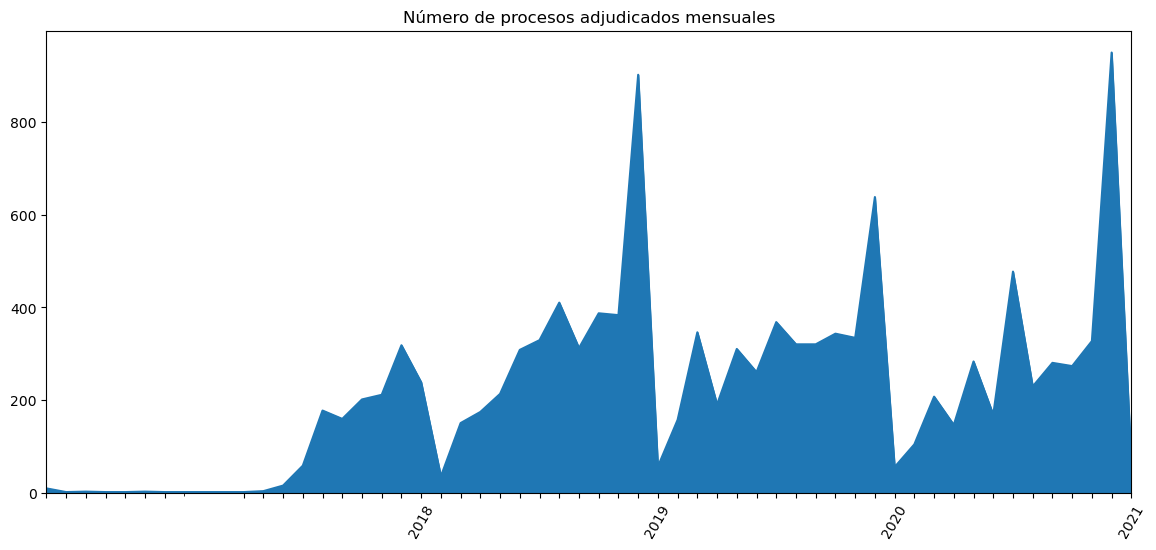

In [30]:
conteo_mensual = secop_22['Fecha Adjudicacion'].dt.to_period('M').value_counts().sort_index()

plt.figure(figsize=(14,6))
conteo_mensual.plot.area(xticks=conteo_mensual.index, rot=60)
plt.title('Número de procesos adjudicados mensuales')

Teniendo en cuenta la duración promedio de un contrato se toman contratos adjudicados hasta julio de 2020, dada la duración promedio de los procesos.

In [31]:
#Filtrar observaciones con fecha de adjudicación menor al 1 de Julio de 2020
secop_23 = secop_22[secop_22['Fecha Adjudicacion'] < pd.to_datetime('2020-07-01')]

In [32]:
secop_23.shape

(9606, 57)

***¡Nos quedamos sin observaciones!*** 

Se descarta esta posibilidad, debido a la fuerte caída en el número de observaciones y la falta de una llave de contratos que permita cruzar con los datos de adiciones. Además, el nivel de agregación de las observaciones no permite realizar el cruce con los datos de adiciones.

Con esto se concluye que procesos de contratación no es la base de datos a usar principalmente, pero algunas variables referentes al proceso de compra pueden ser de útilidad posteriormente.

In [33]:
del secop_23

## Secop II contratos electrónicos

En estos datos cada fila corresponde a un contrato digital, estos datos se encuentran disponibles en la plataforma Datos Abiertos Colombia con el mismo nombre en el siguiente [enlace](https://www.datos.gov.co/Gastos-Gubernamentales/SECOP-II-Contratos-Electr-nicos/jbjy-vk9h).


In [34]:
path = 'secopII_rawdata\SECOP_II_-_Contratos_Electr_nicos.csv'
secop_2ce = pd.read_csv(path)

In [35]:
secop_2ce.shape

(850935, 66)

In [36]:
secop_2ce.columns

Index(['Nombre Entidad', 'Nit Entidad', 'Departamento', 'Ciudad',
       'Localización', 'Orden', 'Sector', 'Rama', 'Entidad Centralizada',
       'Proceso de Compra', 'ID Contrato', 'Referencia del Contrato',
       'Estado Contrato', 'Codigo de Categoria Principal',
       'Descripcion del Proceso', 'Tipo de Contrato',
       'Modalidad de Contratacion', 'Justificacion Modalidad de Contratacion',
       'Fecha de Firma', 'Fecha de Inicio del Contrato',
       'Fecha de Fin del Contrato', 'Fecha de Inicio de Ejecucion',
       'Fecha de Fin de Ejecucion', 'Condiciones de Entrega',
       'TipoDocProveedor', 'Documento Proveedor', 'Proveedor Adjudicado',
       'Es Grupo', 'Es Pyme', 'Habilita Pago Adelantado', 'Liquidación',
       'Obligación Ambiental', 'Obligaciones Postconsumo', 'Reversion',
       'Valor del Contrato', 'Valor de pago adelantado', 'Valor Facturado',
       'Valor Pendiente de Pago', 'Valor Pagado', 'Valor Amortizado',
       'Valor Pendiente de Amortizacion', 'Val

Con el proposito de conservar únicamente las entidades registradas en Bogotá se realizan los primeros filtros acordados respecto al departamento y orden de la entidad.

In [37]:
%%time
#Realizar primer filtro acordado.
secop_2ce_1 = secop_2ce[
    ( (secop_2ce['Departamento'] == 'Distrito Capital de Bogotá') | 
     (secop_2ce['Departamento'] == 'No Definido') ) &
    ( (secop_2ce['Orden'] == 'Territorial') | 
     (secop_2ce['Orden'] == 'Corporación Autónoma'))]

del secop_2ce

Wall time: 568 ms


In [38]:
secop_2ce_1.shape

(239200, 66)

### Filtrar municipios
En linea con los filtros realizados para los procesos de contratación, se procede a verificar las entidades que deben conservarse.

In [39]:
#Confirmar nombres en mayúscula
secop_2ce_1['Nombre Entidad'] = secop_2ce_1['Nombre Entidad'].str.upper()

In [40]:
secop_2ce_1[['Orden', 'Departamento']].value_counts()

Orden                 Departamento              
Territorial           Distrito Capital de Bogotá    235655
Corporación Autónoma  Distrito Capital de Bogotá      3527
Territorial           No Definido                       18
dtype: int64

In [41]:
secop_2ce_1.loc[secop_2ce_1['Orden'] == 'Corporación Autónoma', 'Nombre Entidad'].unique()

array(['CORPORACIÓN DE LA INDUSTRIA AERONÁUTICA COLOMBIANA S.A.',
       'PERSONERIA DE BOGOTA',
       'COMISIÓN PARA EL ESCLARECIMIENTO DE LA VERDAD  LA CONVIVENCIA Y LA NO REPETICIÓN'],
      dtype=object)

Se crea variable para indicar aquellas observaciones con entidades que no corresponden a Bogotá la cual se va marcando a medida que se revisan las entidades.

In [42]:
#Columna que indicará si la observación se refiere a entidades fuera de Bogotá

#Se inicializa con todas las entidades siendo de Bogotá
secop_2ce_1['ENT_NO_BOGOTA'] = 0

#Se marcan entidades de corporación autónoma fuera de Bogotá
secop_2ce_1['ENT_NO_BOGOTA'] = 1*( (secop_2ce_1['Orden']=='Corporación Autónoma') & 
                             (secop_2ce_1['Nombre Entidad']!='PERSONERIA DE BOGOTA') )

In [43]:
secop_2ce_1.loc[(secop_2ce_1['Orden'] == 'Territorial') & (secop_2ce_1['Departamento'] == 'Distrito Capital de Bogotá'),
               'Nombre Entidad'].unique()

array(['SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR E.S.E',
       'SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E.',
       'UNIDAD ADMINISTRATIVA ESPECIAL DE SERVICIOS PÚBLICOS',
       'EMPRESA DE ACUEDUCTO Y ALCANTARILLADO DE BOGOTÁ - E.S.P.',
       'ALCALDIA LOCAL DE SAN CRISTOBAL',
       'SECRETARIA DISTRITAL DE INTEGRACIÓN SOCIAL...',
       'INSTITUTO DISTRITAL DE RECREACIÓN Y DEPORTE',
       'SECRETARIA DISTRITAL DE DESARROLLO ECONOMICO',
       'SUBRED INTEGRADA DE SERVICIOS DE SALUD CENTRO ORIENTE E.S.E',
       'CENTRAL ADMINISTRATIVA Y CONTABLE CENAC PERSONAL',
       'SECRETARÍA DE TRANSPORTE Y MOVILIDAD',
       'FONDO FINANCIERO DISTRITAL DE SALUD..',
       'INSTITUTO DE DESARROLLO URBANO',
       'SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCCIDENTE ESE.',
       'IDIGER', 'SECRETARIA DISTRITAL DE AMBIENTE',
       'INSTITUTO DISTRITAL DE LA PARTICIPACIÓN Y ACCIÓN COMUNAL',
       'ENTIDAD DE GESTION ADMINISTRATIVA Y TECNICA',
       'INSTITUTO DISTRITAL PARA LA

Se confirma que no se presenten entidades de la Gobernación de Cundinamarca o demás entidades nacionales y departamentales que son marcadas en la variable de entidades que no son de Bogotá

In [44]:
#Nombre de las entidades que contienen el nombre cundinamarca o referente a otros departamentos.
dep_pat = 'CUNDINAMARCA|GOBERNACI|DEPARTAMENTAL|NACIONAL|REGIONAL'

print('Observaciones de Entidades referentes a la Gobernación de Cundinamarca u otros departamentos')
print( secop_2ce_1['Nombre Entidad'].str.contains(dep_pat, regex=True).value_counts() )

secop_2ce_1.loc[secop_2ce_1['Nombre Entidad'].str.contains(dep_pat, regex=True), 'ENT_NO_BOGOTA'] = 1

Observaciones de Entidades referentes a la Gobernación de Cundinamarca u otros departamentos
False    230535
True       8665
Name: Nombre Entidad, dtype: int64


In [45]:
#Revisión entidades con Departamento "Distrito Capital de Bogotá"
print('Entidades excluidas')
secop_2ce_1.loc[(secop_2ce_1['Departamento']=='Distrito Capital de Bogotá') & 
             (secop_2ce_1['ENT_NO_BOGOTA']==1), 'Nombre Entidad'].unique()

Entidades excluidas


array(['CORPORACIÓN DE LA INDUSTRIA AERONÁUTICA COLOMBIANA S.A.',
       'SECRETARIA DE CIENCIA TECNOLOGÍA E INNOVACIÓN - DEPARTAMENTO DE CUNDINAMARCA',
       'GOBERNACIÓN DE CUNDINAMARCA - SECRETARÍA DE SALUD',
       'SECRETARÍA DE TECNOLOGÍAS DE LA INFORMACIÓN Y LAS COMUNICACIONES - DEPARTAMENTO DE CUNDINAMARCA',
       'SECRETARÍA DE MINAS  ENERGÍA Y GAS - GOBERNACIÓN DE CUNDINAMARCA',
       'SECRETARIA DE DESARROLLO E INCLUSION SOCIAL GOBERNACION DE CUNDINAMARCA',
       'GOBERNACION DE CUNDINAMARCA SECRETARIA DE GOBIERNO',
       'GOBERNACION DE CUNDINAMARCA - SECRETARIA DE INTEGRACION REGIONAL',
       'SECRETARIA DE COMPETITIVIDAD Y DESARROLLO ECONOMICO DE CUNDINAMARCA',
       'INSTITUTO DEPARTAMENTAL PARA LA RECREACION Y EL DEPORTE DE CUNDINAMARCA',
       'UNIDAD ADMINISTRATIVA ESPECIAL DE PENSIONES DE CUNDINAMARCA',
       'REGIONAL DE ASEGURAMIENTO EN SALUD NO. 1',
       'DEPARTAMENTO DE CUNDINAMARCA - SECRETARIA GENERAL',
       'DEPARTAMENTO DE CUNDINAMARCA - SECRETAR

Se marcan como fuera de Bogotá diversas entidades referentes a municipios o entidades encontradas que no corresponden a la capital.

In [46]:
#Determinar entidades de alcaldias municipales.
mun_pat = ['MUNICIPAL','MUNICIPIO','GACHETA','CHAPARRAL','SONSON',
           'RENTING DE ANTIOQUIA', 'EMPRESA DISTRIBUIDORA DEL PACIFICO S.A. E.S.P',  #Entidades particulares a excluir
           'ASOCIACION AEROPUERTO DEL CAFE', 'EMPRESA SOCIAL DEL ESTADO HOSPITAL JOSE CAYETANO VASQUEZ DE PUERTO BOYACA',
           'HOSPITAL ISMAEL ROLDAN VALENCIA']

print('Observaciones de Entidades referentes a diversos municipios')
print( secop_2ce_1['Nombre Entidad'].str.contains('|'.join(mun_pat), regex=True).value_counts() )

secop_2ce_1.loc[secop_2ce_1['Nombre Entidad'].str.contains('|'.join(mun_pat), regex=True), 'ENT_NO_BOGOTA'] = 1

Observaciones de Entidades referentes a diversos municipios
False    239193
True          7
Name: Nombre Entidad, dtype: int64


In [47]:
#Entidades con Departamento "No Definido" no excluidas previamente
secop_2ce_1.loc[(secop_2ce_1['Departamento']=='No Definido') & 
             (secop_2ce_1['ENT_NO_BOGOTA']==0), 'Nombre Entidad'].unique()

array(['AGENCIA PARA LA GESTIÓN DEL PAISAJE  EL PATRIMONIO Y LAS ALIANZAS PÚBLICO PRIVADAS - APP',
       'INSTITUCION EDUCATIVA SANTA TERESA DE JESUS'], dtype=object)

- INSTITUCION EDUCATIVA SANTA TERESA DE JESUS: escuela de Ibagué
- AGENCIA PARA LA GESTIÓN DEL PAISAJE  EL PATRIMONIO Y LAS ALIANZAS PÚBLICO PRIVADAS: Agencia de Medellín

Marcar como no Bogotá las entidades restantes con departamento no definido.

In [48]:
secop_2ce_1.loc[(secop_2ce_1['Departamento']=='No Definido') & 
             (secop_2ce_1['ENT_NO_BOGOTA']==0), 'ENT_NO_BOGOTA'] = 1

Datos confirmados con solo Bogotá (secop_2ce_**2**)

In [50]:
secop_2ce_1.loc[secop_2ce_1['ENT_NO_BOGOTA']==0, 'Departamento'] = 'Distrito Capital de Bogotá'

secop_2ce_2 = secop_2ce_1[secop_2ce_1['ENT_NO_BOGOTA']==0].drop(columns='ENT_NO_BOGOTA').reset_index(drop=True)

### Filtrar estatus de contratos
El proposito de este es conservar aquellas observaciones para las cuales se pueda conseguir información posterior a la realización de la actividad. Con lo cual se determina la variable respuesta. La variable de estado del contrato que se marca puede no ser actualizada.

In [51]:
secop_2ce_2.shape

(228561, 66)

In [52]:
secop_2ce_2.head(3)

,Nombre Entidad,Nit Entidad,Departamento,Ciudad,Localización,Orden,Sector,Rama,Entidad Centralizada,Proceso de Compra,ID Contrato,Referencia del Contrato,Estado Contrato,Codigo de Categoria Principal,Descripcion del Proceso,Tipo de Contrato,Modalidad de Contratacion,Justificacion Modalidad de Contratacion,Fecha de Firma,Fecha de Inicio del Contrato,Fecha de Fin del Contrato,Fecha de Inicio de Ejecucion,Fecha de Fin de Ejecucion,Condiciones de Entrega,TipoDocProveedor,Documento Proveedor,Proveedor Adjudicado,Es Grupo,Es Pyme,Habilita Pago Adelantado,Liquidación,Obligación Ambiental,Obligaciones Postconsumo,Reversion,Valor del Contrato,Valor de pago adelantado,Valor Facturado,Valor Pendiente de Pago,Valor Pagado,Valor Amortizado,Valor Pendiente de Amortizacion,Valor Pendiente de Ejecucion,Estado BPIN,Código BPIN,Anno BPIN,Saldo CDP,Saldo Vigencia,EsPostConflicto,URLProceso,Destino Gasto,Origen de los Recursos,Dias Adicionados,Puntos del Acuerdo,Pilares del Acuerdo,Nombre Representante Legal,Nacionalidad Representante Legal,Tipo de Identificación Representante Legal,Identificación Representante Legal,Género Representante Legal,Presupuesto General de la Nacion – PGN,Sistema General de Participaciones,Sistema General de Regalías,"Recursos Propios (Alcaldías, Gobernaciones y Resguardos Indígenas)",Recursos de Credito,Recursos Propios,Ultima Actualizacion
0,SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR E.S.E,9009585649,Distrito Capital de Bogotá,Bogotá,"Colombia, Bogotá, Bogotá",Territorial,Salud y Protección Social,Ejecutivo,Descentralizada,CO1.BDOS.365219,CO1.PCCNTR.360614,5031-2018,En aprobación,V1.80111701,PRESTAR SERVICIOS DE APOYO A LA GESTIÓN ADMINISTRATIVA EN LA SUBRED INTEGRADA DE SERVICIOS DE SA...,Prestación de servicios,Contratación régimen especial,Regla aplicable,NaN,03/01/2018,05/31/2018,03/01/2018,05/31/2018,A convenir,Cédula de Ciudadanía,51971406,LUZ DARY IBAÑEZ PINILLA,No,No,No,No,No,No,No,4518639,0,0,4518639,0,0,0,4518639,Válido,No Definido,N/D,3300000000000.000,0,No,https://community.secop.gov.co/Public/Tendering/OpportunityDetail/Index?noticeUID=CO1.NTC.361016...,Funcionamiento,Distribuido,0,No aplica,No aplica,No Definido,No Definido,No Definido,No Definido,No Definido,0.000,0.000,0.000,0.000,0.000,0.000,09/06/2018 12:00:00 AM
1,SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E.,900971006,Distrito Capital de Bogotá,No Definido,"Colombia, Bogotá, Bogotá",Territorial,Salud y Protección Social,Corporación Autónoma,Descentralizada,CO1.BDOS.1168235,CO1.PCCNTR.1458238,CPS-2961-2020,Modificado,V1.85101600,AUXILIAR DE ENFERMERIA Y/O TECN?LOGO EN ATENCI?N PREHOSPITALARIA - Convenio 0103 de 2020,DecreeLaw092/2017,Contratación régimen especial,Decree092/2017,03/31/2020,03/01/2020,11/30/2020,12/01/2020,01/15/2021,A convenir,Cédula de Ciudadanía,53073539,VIVIANA CONTRERAS TORRES,No,No,No,No,No,No,No,15433332,0,0,15433332,0,0,0,15433332,Válido,No Definido,2019,657970782.000,0,No,https://community.secop.gov.co/Public/Tendering/OpportunityDetail/Index?noticeUID=CO1.NTC.116692...,Funcionamiento,Distribuido,243,No aplica,No aplica,No Definido,No Definido,No Definido,No Definido,No Definido,0.000,0.000,0.000,0.000,0.000,0.000,01/11/2021 12:00:00 AM
2,UNIDAD ADMINISTRATIVA ESPECIAL DE SERVICIOS PÚBLICOS,900126860,Distrito Capital de Bogotá,Bogotá,"Colombia, Bogotá, Bogotá",Territorial,Ambiente y Desarrollo Sostenible,Ejecutivo,Descentralizada,CO1.BDOS.1159821,CO1.PCCNTR.1442517,UAESP-065-2020,Activo,V1.80161500,Prestar los servicios de apoyo a la Subdirección de Aprovechamiento en el desarrollo de las camp...,Prestación de servicios,Contratación directa,ServiciosProfesionales,03/11/2020,03/12/2020,09/11/2020,03/12/2020,09/11/2020,Como acordado previamente,Cédula de Ciudadanía,1031147678,ALEJANDRA LIEVANO VALLECILLA,No,No,No,No,No,No,No,28620000,0,0,28620000,0,0,0,28620000,Válido,No Definido,N/D,0.000,0,No,https://community.secop.gov.co/Public/Tendering/OpportunityDetail/Index?noticeUID=CO1.NTC.115855...,Funcionamiento,Distribuido,0,

In [53]:
secop_2ce_2['Estado Contrato'].value_counts()

Modificado           103959
Activo                45932
En ejecución          30148
Borrador              14525
terminado             11230
enviado Proveedor      6912
En aprobación          6477
Cancelado              5208
Cerrado                1921
cedido                 1880
Suspendido              364
Prorrogado                5
Name: Estado Contrato, dtype: int64

Filtrar acá y agregar columnas de la anterior.

In [54]:
display( pd.crosstab(secop_2ce_2['Estado Contrato'], ~secop_2ce_2['Fecha de Firma'].isna(), 
                     margins=True, colnames=['Presenta fecha firma']) )

display( pd.crosstab(secop_2ce_2['Estado Contrato'], ~secop_2ce_2['Fecha de Fin del Contrato'].isna(), 
                     margins=True, colnames=['Presenta fecha de fin del contrato']) )

display( pd.crosstab(secop_2ce_2['Estado Contrato'], ~secop_2ce_2['Fecha de Fin de Ejecucion'].isna(), 
                     margins=True, colnames=['Presenta fecha de fin de ejecució del contrato']) )

Presenta fecha firma,False,True,All
Estado Contrato,,,
Activo,4,45928,45932
Borrador,14411,114,14525
Cancelado,5204,4,5208
Cerrado,0,1921,1921
En aprobación,6476,1,6477
En ejecución,0,30148,30148
Modificado,10,103949,103959
Prorrogado,0,5,5
Suspendido,0,364,364


Presenta fecha de fin del contrato,False,True,All
Estado Contrato,,,
Activo,1,45931,45932
Borrador,5387,9138,14525
Cancelado,2586,2622,5208
Cerrado,0,1921,1921
En aprobación,0,6477,6477
En ejecución,0,30148,30148
Modificado,0,103959,103959
Prorrogado,0,5,5
Suspendido,0,364,364


Presenta fecha de fin de ejecució del contrato,False,True,All
Estado Contrato,,,
Activo,16570,29362,45932
Borrador,10421,4104,14525
Cancelado,4075,1133,5208
Cerrado,272,1649,1921
En aprobación,4351,2126,6477
En ejecución,30148,0,30148
Modificado,46444,57515,103959
Prorrogado,0,5,5
Suspendido,168,196,364


In [55]:
display( pd.crosstab([ ~secop_2ce_2['Fecha de Firma'].isna(), ~secop_2ce_2['Fecha de Inicio de Ejecucion'].isna(),
                     ~secop_2ce_2['Fecha de Fin de Ejecucion'].isna()], 
                     secop_2ce_2['Estado Contrato'], 
                     margins=True) )

Estado Contrato                                                        Activo  \
Fecha de Firma Fecha de Inicio de Ejecucion Fecha de Fin de Ejecucion           
False          False                        False                           2   
                                            True                            0   
               True                         False                           0   
                                            True                            2   
True           False                        False                       16552   
                                            True                           98   
               True                         False                          16   
                                            True                        29262   
All                                                                     45932   

Estado Contrato                                                        Borrador  \
Fecha de Firma Fecha de Inicio de Ejecucion Fecha de Fin de Ejecucion             
False          False                        False                         10398   
                                            True                            187   
               True                         False                             4   
                                            True                           3822   
True           False                        False                            19   
                                            True                              0   
               True                         False                             0   
                                            True                             95   
All                                                                       14525   

Estado Contrato                                                        Cancelado  \
Fecha de Firma Fecha de Inicio de Ejecucion Fecha de Fin de Ejecucion              
False          False                        False                           4068   
                                            True                               4   
               True                         False                              6   
                                            True                            1126   
True           False                        False                              1   
                                            True                               0   
               True                         False                              0   
                                            True                               3   
All                                                                         5208   

Estado Contrato                                                        Cerrado  \
Fecha de Firma Fecha de Inicio de Ejecucion Fecha de Fin de Ejecucion            
False          False                        False                            0   
                                            True                             0   
               True                         False                            0   
                                            True                             0   
True           False                        False                          272   
                                            True                             3   
               True                         False                            0   
                                            True                          1646   
All                                                                       1921   

Estado Contrato                                                        En aprobación  \
Fecha de Firma Fecha de Inicio de Ejecucion Fecha de Fin de Ejecucion                  
False          False                        False                               4351   
                                            True                                  51   
              

In [56]:
display( pd.crosstab(~secop_2ce_2['Fecha de Firma'].isna(),  ~secop_2ce_2['Fecha de Fin del Contrato'].isna() , 
                     margins=True) )

display( pd.crosstab(~secop_2ce_2['Fecha de Firma'].isna(),  ~secop_2ce_2['Fecha de Fin de Ejecucion'].isna() , 
                     margins=True) )

display( pd.crosstab(~secop_2ce_2['Fecha de Fin del Contrato'].isna(),  ~secop_2ce_2['Fecha de Fin de Ejecucion'].isna() , 
                     margins=True) )

display( pd.crosstab(~secop_2ce_2['Fecha de Inicio de Ejecucion'].isna(),  ~secop_2ce_2['Fecha de Fin de Ejecucion'].isna() , 
                     margins=True) )

Fecha de Fin del Contrato,False,True,All
Fecha de Firma,,,
False,7972,25037,33009
True,2,195550,195552
All,7974,220587,228561


Fecha de Fin de Ejecucion,False,True,All
Fecha de Firma,,,
False,23616,9393,33009
True,99276,96276,195552
All,122892,105669,228561


Fecha de Fin de Ejecucion,False,True,All
Fecha de Fin del Contrato,,,
False,7969,5,7974
True,114923,105664,220587
All,122892,105669,228561


Fecha de Fin de Ejecucion,False,True,All
Fecha de Inicio de Ejecucion,,,
False,122828,3496,126324
True,64,102173,102237
All,122892,105669,228561


In [57]:
secop_2ce_2[secop_2ce_2['Estado Contrato']=='terminado'].sample(3)

,Nombre Entidad,Nit Entidad,Departamento,Ciudad,Localización,Orden,Sector,Rama,Entidad Centralizada,Proceso de Compra,ID Contrato,Referencia del Contrato,Estado Contrato,Codigo de Categoria Principal,Descripcion del Proceso,Tipo de Contrato,Modalidad de Contratacion,Justificacion Modalidad de Contratacion,Fecha de Firma,Fecha de Inicio del Contrato,Fecha de Fin del Contrato,Fecha de Inicio de Ejecucion,Fecha de Fin de Ejecucion,Condiciones de Entrega,TipoDocProveedor,Documento Proveedor,Proveedor Adjudicado,Es Grupo,Es Pyme,Habilita Pago Adelantado,Liquidación,Obligación Ambiental,Obligaciones Postconsumo,Reversion,Valor del Contrato,Valor de pago adelantado,Valor Facturado,Valor Pendiente de Pago,Valor Pagado,Valor Amortizado,Valor Pendiente de Amortizacion,Valor Pendiente de Ejecucion,Estado BPIN,Código BPIN,Anno BPIN,Saldo CDP,Saldo Vigencia,EsPostConflicto,URLProceso,Destino Gasto,Origen de los Recursos,Dias Adicionados,Puntos del Acuerdo,Pilares del Acuerdo,Nombre Representante Legal,Nacionalidad Representante Legal,Tipo de Identificación Representante Legal,Identificación Representante Legal,Género Representante Legal,Presupuesto General de la Nacion – PGN,Sistema General de Participaciones,Sistema General de Regalías,"Recursos Propios (Alcaldías, Gobernaciones y Resguardos Indígenas)",Recursos de Credito,Recursos Propios,Ultima Actualizacion
26645,ORQUESTA FILARMONICA DE BOGOTA,899999282,Distrito Capital de Bogotá,Bogotá,"Colombia, Bogotá, Bogotá",Territorial,Cultura,Ejecutivo,Descentralizada,CO1.BDOS.366262,CO1.PCCNTR.378146,131-2018,terminado,V1.81112501,Renovación y actualización de la suscripción de licencias de software para la Orquesta Filarmóni...,Compraventa,Mínima cuantía,Presupuesto inferior al 10% de la menor cuantía,03/21/2018,03/26/2018,02/08/2019,04/09/2018,02/08/2019,A convenir,NIT,9004466481,Green Fon Group SAS,No,Si,No,Si,No,No,No,9102000,0,9102000,9102000,0,0,0,9102000,Válido,No Definido,2018,9506748.000,0,No,https://community.secop.gov.co/Public/Tendering/OpportunityDetail/Index?noticeUID=CO1.NTC.364828...,Inversión,Distribuido,0,No aplica,No aplica,No Definido,No Definido,No Definido,No Definido,No Definido,0.000,0.000,0.000,0.000,0.000,0.000,08/14/2019 12:00:00 AM
185651,UNIDAD ADMINISTRATIVA ESPECIAL DE REHABILITACIÓN Y MANTENIMIENTO VIAL,900127032,Distrito Capital de Bogotá,Bogotá,"Colombia, Bogotá, Bogotá",Territorial,Servicio Público,Ejecutivo,Centralizada,CO1.BDOS.255776,CO1.PCCNTR.266305,CO1.PCCNTR.266305,terminado,V1.43222501,ADQUISICIÓN DE EQUIPOS Y ELEMENTOS DE RED DE DATOS PARA LA UNIDAD ADMINISTRATIVA ESPECIAL DE REH...,Compraventa,Selección abreviada subasta inversa,Suministro de bienes y servicios de características técnicas uniformes y común utilización,02/14/2018,01/05/2018,05/31/2018,01/24/2018,05/31/2018,A convenir,NIT,900425697,Adsum Soluciones Tecnológicas SAS,No,Si,No,No,No,No,No,87533271,0,0,87533271,0,0,0,87533271,Válido,No Definido,2018,108473805.000,0,No,https://community.secop.gov.co/Public/Tendering/OpportunityDetail/Index?noticeUID=CO1.NTC.263446...,Funcionamiento,Distribuido,0,No aplica,No aplica,No Definido,No Definido,No Definido,No Definido,No Definido,0.000,0.000,0.000,0.000,0.000,0.000,10/18/2020 12:00:00 AM
111314,SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCCIDENTE ESE.,900959048,Distrito Capital de Bogotá,No Definido,"Colombia, Bogotá, Bogotá",Territorial,Salud y Protección Social,Ejecutivo,Descentralizada,CO1.BDOS.1066239,CO1.PCCNTR.1315102,2748-2020,terminado,V1.80111600,Prestar servicios a la gestion administrativa y/o asistencial dentro de los diferentes procesos...,Prestación de servicios,Contratación régimen especial,Regla aplicable,01/31/2020,02/01/2020,07/31/2020,NaN,NaN,No Definido,Cédula de Ciudadanía,1033774381,zulma lorena martinez sepulveda,No,No,No,No,No,No,No,10574550,0,0,10574550,0,0,0,10574550,Válido,No Definido,2018,63300000000.000,0,No,https://community.secop.gov.co/Public/Tendering/OpportunityDetail/Index?noticeUID=CO1.NTC.106531...,Funcionamie

Dado que el estado del contrato puede no ser claro y requiere ser actualizado, se filtran las observaciones que contengan fecha de inicio y fin de ejecución, y además hayan sido adjudicadas. Luego solo se conservan aquellos contratos con fecha de ejecución hasta el 31 de diciembre de 2020 y que presenten el proveedor adjudicado. Luego se excluyen los contratos con estados en borrador y aprobación.


In [58]:
#Variable para indicar los contratos finalizados a utilizar
secop_2ce_2['Contratos_finalizados'] = 1*(~secop_2ce_2['Fecha de Inicio de Ejecucion'].isna())*\
                                        (~secop_2ce_2['Fecha de Fin de Ejecucion'].isna())

secop_2ce_2['Contratos_finalizados'].value_counts()

0    126388
1    102173
Name: Contratos_finalizados, dtype: int64

In [59]:
#Dar formato de fecha para comparar
secop_2ce_2['Fecha de Fin de Ejecucion'] = pd.to_datetime(secop_2ce_2['Fecha de Fin de Ejecucion'], format='%m/%d/%Y')

In [60]:
(secop_2ce_2['Fecha de Fin de Ejecucion'] > pd.to_datetime('2020-12-31')).value_counts()

False    219811
True       8750
Name: Fecha de Fin de Ejecucion, dtype: int64

In [61]:
# Desmarcar de finalizados aquellos que presentan fecha de fin de ejecución superior al 30 de diciembre de 2020
secop_2ce_2.loc[(secop_2ce_2['Contratos_finalizados']==1) & 
                (secop_2ce_2['Fecha de Fin de Ejecucion'] > pd.to_datetime('2020-12-31')) , 
               'Contratos_finalizados'] = 0

#Desmarcar de finalizados aquellas observaciones que no presentan proveedor adjudicado
secop_2ce_2.loc[(secop_2ce_2['Contratos_finalizados']==1) & (secop_2ce_2['Proveedor Adjudicado']=='No Definido' ) , 
               'Contratos_finalizados'] = 0

In [62]:
secop_2ce_2['Contratos_finalizados'].value_counts()

0    135440
1     93121
Name: Contratos_finalizados, dtype: int64

Revisar estado de los contratos.

In [63]:
secop_2ce_2.loc[secop_2ce_2['Contratos_finalizados']==1, 'Estado Contrato'].value_counts().to_frame()

,Estado Contrato
Modificado,47298
Activo,28618
terminado,6095
Borrador,3661
En aprobación,2073
Cerrado,1646
enviado Proveedor,1608
cedido,982
Cancelado,963
Suspendido,172


In [64]:
secop_2ce_2[(secop_2ce_2['Contratos_finalizados']==1) & (secop_2ce_2['Estado Contrato']=='enviado Proveedor')].sample(3)

,Nombre Entidad,Nit Entidad,Departamento,Ciudad,Localización,Orden,Sector,Rama,Entidad Centralizada,Proceso de Compra,ID Contrato,Referencia del Contrato,Estado Contrato,Codigo de Categoria Principal,Descripcion del Proceso,Tipo de Contrato,Modalidad de Contratacion,Justificacion Modalidad de Contratacion,Fecha de Firma,Fecha de Inicio del Contrato,Fecha de Fin del Contrato,Fecha de Inicio de Ejecucion,Fecha de Fin de Ejecucion,Condiciones de Entrega,TipoDocProveedor,Documento Proveedor,Proveedor Adjudicado,Es Grupo,Es Pyme,Habilita Pago Adelantado,Liquidación,Obligación Ambiental,Obligaciones Postconsumo,Reversion,Valor del Contrato,Valor de pago adelantado,Valor Facturado,Valor Pendiente de Pago,Valor Pagado,Valor Amortizado,Valor Pendiente de Amortizacion,Valor Pendiente de Ejecucion,Estado BPIN,Código BPIN,Anno BPIN,Saldo CDP,Saldo Vigencia,EsPostConflicto,URLProceso,Destino Gasto,Origen de los Recursos,Dias Adicionados,Puntos del Acuerdo,Pilares del Acuerdo,Nombre Representante Legal,Nacionalidad Representante Legal,Tipo de Identificación Representante Legal,Identificación Representante Legal,Género Representante Legal,Presupuesto General de la Nacion – PGN,Sistema General de Participaciones,Sistema General de Regalías,"Recursos Propios (Alcaldías, Gobernaciones y Resguardos Indígenas)",Recursos de Credito,Recursos Propios,Ultima Actualizacion,Contratos_finalizados
129745,SUBRED INTEGRADA DE SERVICIOS DE SALUD CENTRO ORIENTE E.S.E,900959051,Distrito Capital de Bogotá,No Definido,"Colombia, Bogotá, Bogotá",Territorial,Salud y Protección Social,Ejecutivo,Descentralizada,CO1.BDOS.783661,CO1.PCCNTR.883151,PS 3598 2019,enviado Proveedor,V1.80111600,PRESTAR SUS SERVICIOS DE APOYO DE MANERA PERSONAL Y AUTÓNOMA PARA LA EJECUCIÓN DE ACTIVIDADES AD...,Prestación de servicios,Contratación régimen especial,Regla aplicable,NaN,03/11/2019,09/10/2019,03/11/2019,2019-09-10,A convenir,NIT,53038516,Diana Marcela Velasco 53038516,No,No,No,No,No,No,No,8780000,0,0,8780000,0,0,0,8780000,Válido,No Definido,N/D,0.000,0,No,https://community.secop.gov.co/Public/Tendering/OpportunityDetail/Index?noticeUID=CO1.NTC.774140...,Funcionamiento,Distribuido,0,No aplica,No aplica,No Definido,No Definido,No Definido,No Definido,No Definido,0.000,0.000,0.000,0.000,0.000,0.000,03/12/2019 12:00:00 AM,1
148857,SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E.,900971006,Distrito Capital de Bogotá,No Definido,"Colombia, Bogotá, Bogotá",Territorial,Salud y Protección Social,Corporación Autónoma,Descentralizada,CO1.BDOS.421343,CO1.PCCNTR.420943,CPS-4516-2018,enviado Proveedor,V1.85101600,PRESTACION DE SERVICIOS PROFESIONALES APOYO A LA GESTION COMO AUXILIAR DE ENFERMERIA,Prestación de servicios,Contratación directa,ServiciosProfesionales,NaN,05/02/2018,07/31/2018,05/02/2018,2018-07-31,A convenir,Cédula de Ciudadanía,1014197461,Maria alejandra pineda florez,No,No,No,No,No,No,No,1514412,0,0,1514412,0,0,0,1514412,Válido,No Definido,N/D,0.000,0,No,https://community.secop.gov.co/Public/Tendering/OpportunityDetail/Index?noticeUID=CO1.NTC.422765...,Funcionamiento,Distribuido,0,No aplica,No aplica,No Definido,No Definido,No Definido,No Definido,No Definido,0.000,0.000,0.000,0.000,0.000,0.000,09/06/2018 12:00:00 AM,1
169925,SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR E.S.E,9009585649,Distrito Capital de Bogotá,Bogotá,"Colombia, Bogotá, Bogotá",Territorial,Salud y Protección Social,Ejecutivo,Descentralizada,CO1.BDOS.1160403,CO1.PCCNTR.1443301,4224-2020,enviado Proveedor,V1.80111701,PRESTAR SERVICIOS DE APOYO A LA GESTION ASISTENCIAL,Prestación de servicios,Contratación régimen especial,Regla aplicable,NaN,03/12/2020,06/30/2020,03/12/2020,2020-06-30,A convenir,NIT,1026584776,Sara Carolina Martinez Roman,No,Si,No,No,No,No,No,18581772,0,0,18581772,0,0,0,18581772,Válido,No Definido,N/D,0.000,0,No,https://community.secop.gov.co/Public/Tendering/OpportunityDetail/Index?noticeUID=CO1.NTC.115920...,Funcionamiento,Distribuido,0,No aplica,No aplica,No Definido,No Definido,No Definido,

Se excluyen contratos en aprobacion y borrador.

Se conservan los contratos prorrogados; suspendidos(descripción [aquí](https://sintesis.colombiacompra.gov.co/sintesis/2-etapa-contractual-suspensi%C3%B3n-de-la-ejecuci%C3%B3n-del-contrato)); cedidos, dado que finaliza para un proveedor(descripción [aquí](https://www.colombiacompra.gov.co/content/modificaciones-del-contrato-11)); terminado. Demás estados se conservan al no tener información que sustente excluirlas


In [65]:
secop_2ce_2.loc[secop_2ce_2['Contratos_finalizados']==1,'Estado Contrato'].unique()

array(['En aprobación', 'Activo', 'Modificado', 'terminado', 'Borrador',
       'Cerrado', 'cedido', 'enviado Proveedor', 'Cancelado',
       'Suspendido', 'Prorrogado'], dtype=object)

In [66]:
#Desmarcar observaciones con estados de contrato a excluir.
secop_2ce_2.loc[(secop_2ce_2['Contratos_finalizados']==1) & 
                (secop_2ce_2['Estado Contrato'].str.contains('En aprobación|Borrador') ) , 
               'Contratos_finalizados'] = 0

In [67]:
secop_2ce_2['Contratos_finalizados'].value_counts()

0    141174
1     87387
Name: Contratos_finalizados, dtype: int64

Datos filtrados con contratos que se asumen finalizados (secop_2ce_**3**)

In [68]:
secop_2ce_3 = secop_2ce_2[secop_2ce_2['Contratos_finalizados']==1].drop(columns='Contratos_finalizados').reset_index(drop=True)
secop_2ce_3.shape

(87387, 66)

Se obtiene una base de datos donde cada fila corresponde a un contrato al que pueden haberse impuesto sanciones y ha sido generado por entidades del distrito capital.

Borrar variables inncesarias para liberar espacio.

In [69]:
del conteo_mensual
del dias_duracion
del secop_2ce_1
del secop_2ce_2

## Adicionar variables a contratos electrónicos.
Tomando como base contratos electrónicos se agregarán variables provenientes de otras fuentes de información, tales como demás bases de datos públicas de [secop II](https://www.colombiacompra.gov.co/transparencia/conjuntos-de-datos-abiertos), el registro de multas impuestas por la Superintendencia de Industria y Comercio, y los códigos de productos y servicios UNSPSC.

### Agregar datos a nivel de portafolio a contratos electrónicos.
Este proceso se realiza mediante los datos de procesos de contratación filtrados previamente, las variables que identifican el proceso de compra en procesos de contratación y contratos electrónicos son 'Proceso de Compra' y 'ID del Portafolio', respectivamente.

In [70]:
#Revisión de los identificadores
print('Filas duplicadas:', secop_2ce_3.duplicated().sum())  #Verificar que no hayan filas duplicadas
print('ID contrato duplicados:', secop_2ce_3['ID Contrato'].duplicated().sum())  #Confirmar ID Contrato como llave primaria
print('Proceso de compra duplicados:', secop_2ce_3['Proceso de Compra'].duplicated().sum())

Filas duplicadas: 0
ID contrato duplicados: 0
Proceso de compra duplicados: 20694


In [71]:
#Revisión de los identificadores
print('ID proceso duplicados en Secop procesos:',secop_22['ID del Proceso'].duplicated().sum() )
print('ID portafolio duplicados en Secop procesos:',secop_22['ID del Portafolio'].duplicated().sum() )

ID proceso duplicados en Secop procesos: 1967
ID portafolio duplicados en Secop procesos: 6410


**Cruce directo**

Realizar cruce mediante identificador del proceso de compra, id del portafolio para los datos de procesos de contratación.

In [72]:
secop_2cepc = secop_2ce_3.merge(secop_22, left_on=['Proceso de Compra'], 
                                right_on=['ID del Portafolio'],
                                how='left', indicator=True)
secop_2cepc.shape

(98732, 124)

Verificación del cruce

In [73]:
secop_2cepc['_merge'].value_counts()

both          94160
left_only      4572
right_only        0
Name: _merge, dtype: int64

In [74]:
#Debido a que las llaves se repiten en amba bases de datos se crean repeticiones de varias observaciones
secop_2cepc['Proceso de Compra'].duplicated().sum()

32039

In [75]:
pd.set_option("display.max_rows", None)
display( pd.concat([pd.Series(secop_2cepc.columns[:66]),pd.Series(secop_2cepc.columns[66:])], axis=1) )
pd.set_option("display.max_rows", 10)

,0,1
0,Nombre Entidad,Entidad
1,Nit Entidad_x,Nit Entidad_y
2,Departamento,Departamento Entidad
3,Ciudad,Ciudad Entidad
4,Localización,OrdenEntidad
5,Orden,Entidad Centralizada_y
6,Sector,ID del Proceso
7,Rama,Referencia del Proceso
8,Entidad Centralizada_x,PCI
9,Proceso de Compra,ID del Portafolio


In [76]:
del secop_2cepc

Se puede ver que debido a los valores duplicados de la llave usada en ambos conjuntos de datos se crean observaciones adicionales sin sustentación alguna, por lo cual se descarta el cruce anterior. Para solucionar esto se creará una base al nivel de portafolios con `secop_22`, procesos de contratación. De tal manera que el ID Portafolio sea único, y de esta manera se puede agregar al contrato información referente al proceso de contratación.

#### Crear base a nivel de portafolio

Como se menciona previamente, a continuación se resume la información de Secop II procesos de contratación para llevarla a un nivel de agregación de portafolio o proceso de compra y poder agregar tal información a contratos electrónicos.

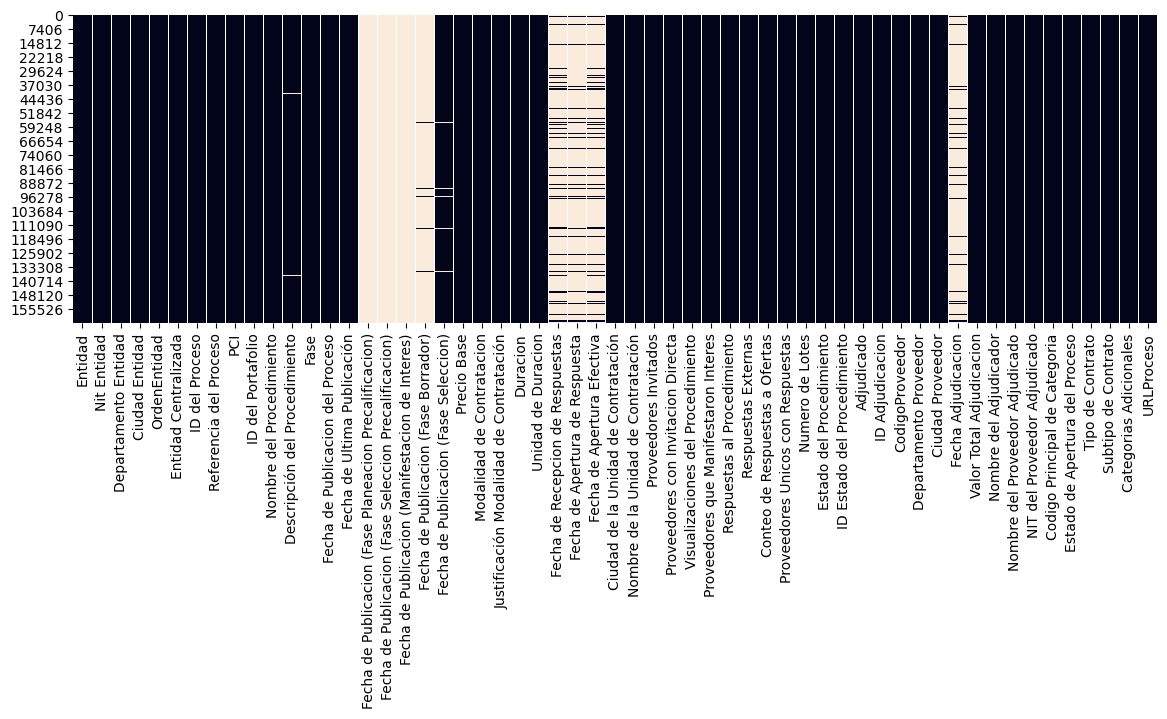

In [77]:
plt.figure(figsize=(14,4))
sns.heatmap(secop_22.isnull(), cbar=False)

In [78]:
%%time
# Determinar variables de secop_22 que son referentes al proceso de compra, ID Portafolio
print('Número de filas esperadas:', secop_22['ID del Portafolio'].unique().shape[0])

# Tarda mucho la ejecución, pero ayuda a saber que variables no varián en un mismo portafolio.
# display( secop_22.groupby('ID del Portafolio').agg(lambda x: len(x.unique())).agg([max, 'mean']) ) 

Número de filas esperadas: 156520
Wall time: 78 ms


Determinar variables que ya están a nivel de portafolio y cuales deben resumirse, así mismo se escogen aquellas que brindan información adicional a la contenida en contratos electrónicos.

Variables que no cambian para un mismo portafolio (proceso de compra): Descripciones de la *Entidad*, 'PCI', 'Modalidad de Contratacion', 'Justificación Modalidad de Contratación', 'Duracion', 'Unidad de Duracion', 'Ciudad de la Unidad de Contratación', 'Nombre de la Unidad de Contratación', 'Visualizaciones del Procedimiento', 'Proveedores que Manifestaron Interes', 'Tipo de Contrato', 'Subtipo de Contrato'.

Variables de procesos de contratación que no tiene contratos electrónicos y pueden ser de utilidad: 'ID del Portafolio', 'PCI', 'Fecha de Publicacion del Proceso', 'Fecha de Ultima Publicación', 'Precio Base', 'Duracion', 'Unidad de Duracion', 'Ciudad de la Unidad de Contratación', 'Proveedores Invitados', 'Proveedores con Invitacion Directa', 'Visualizaciones del Procedimiento', 'Proveedores que Manifestaron Interes', 'Respuestas al Procedimiento', 'Respuestas Externas', 'Conteo de Respuestas a Ofertas', 'Proveedores Unicos con Respuestas' y 'Numero de Lotes'.

In [79]:
#Resumir a las variables deseadas
var_port = [ 'ID del Portafolio', 'ID del Proceso','PCI', 'Fecha de Publicacion del Proceso',
            'Fecha de Ultima Publicación', 'Precio Base', 'Duracion', 'Unidad de Duracion', 
            'Ciudad de la Unidad de Contratación', 'Proveedores Invitados',
            'Proveedores con Invitacion Directa', 'Visualizaciones del Procedimiento', 'Proveedores que Manifestaron Interes',
            'Respuestas al Procedimiento', 'Respuestas Externas', 'Conteo de Respuestas a Ofertas',
            'Proveedores Unicos con Respuestas','Numero de Lotes'
           ]
secop_2port = secop_22[var_port]
secop_2port.shape

(162930, 18)

In [80]:
#Número de observaciones objetivo
len(secop_2port['ID del Portafolio'].unique())

156520

In [81]:
#Eliminar observaciones duplicadas
secop_2port = secop_2port.drop_duplicates(ignore_index=True)
secop_2port.shape

(160963, 18)

In [82]:
print('Portafolios duplicados a conciliar:', secop_2port['ID del Portafolio'].duplicated().sum())

Portafolios duplicados a conciliar: 4443


In [83]:
#secop_2port[secop_2port['ID del Portafolio'].duplicated(keep=False)].sort_values('ID del Portafolio').tail(6)

Para un mismo portafolio se abren varios procesos (por esto las duplicaciones), estos se contarán y se sumaran entre repeticiones de `ID del Portafolio` las variables 'Proveedores Invitados', 'Proveedores con Invitacion Directa', 'Visualizaciones del Procedimiento', 'Proveedores que Manifestaron Interes', 'Respuestas al Procedimiento', 'Respuestas Externas', 'Conteo de Respuestas a Ofertas', 'Proveedores Unicos con Respuestas' y 'Numero de Lotes'.

La variable 'Fecha de Publicacion del Proceso' tomará la fecha más antigua entre las presentes para ella y 'Fecha de Ultima Publicación'  tomará la fecha más reciente entre las presentes para ella.

Para 'Precio Base' se tomará el valor promedio de estos, debe tenerse en cuenta al momento de revisar las columnas de la base final que se han encontrado irregularidades en estos datos. Se conservan debido a que pueden hacer de buen descriptor, pero deben tenerse en cuenta tales datos irregulares.

In [84]:
#Conteo de procesos por portafolio
secop_2port['Numero_de_procesos_reportados'] = secop_2port['ID del Portafolio'
                                                          ].map( secop_2port['ID del Portafolio'].value_counts() )

In [85]:
#Base con suma de variables
#Variables invitaciones
var_inv = ['Proveedores Invitados', 'Proveedores con Invitacion Directa', 'Visualizaciones del Procedimiento', 
           'Proveedores que Manifestaron Interes', 'Respuestas al Procedimiento', 'Respuestas Externas', 
           'Conteo de Respuestas a Ofertas', 'Proveedores Unicos con Respuestas', 'Numero de Lotes']

#Información de las invitaciones de cada portafolio 
#En esta base para cada variable listada se suman las filas con un mismo portafolio
inv_port = secop_2port[var_inv + ['ID del Portafolio']].groupby('ID del Portafolio'
                                                               ).sum().reset_index()

In [86]:
#Fechas de publicación
#Dar formato de fecha.
secop_2port['Fecha de Publicacion del Proceso'] = pd.to_datetime(secop_2port['Fecha de Publicacion del Proceso'], 
                                                                 format='%m/%d/%Y')
secop_2port['Fecha de Ultima Publicación'] = pd.to_datetime(secop_2port['Fecha de Ultima Publicación'], 
                                                            format='%m/%d/%Y')

var_fechas = ['Fecha de Publicacion del Proceso', 'Fecha de Ultima Publicación', 'Precio Base']
#Indicación de las fechas de publicación de cada portafolio + precio base promedio.
fechas_port = secop_2port[var_fechas + ['ID del Portafolio']
                         ].groupby('ID del Portafolio'
                                  ).agg({'Fecha de Publicacion del Proceso': min,  #Fecha más antigua
                                         'Fecha de Ultima Publicación': max,  #Fecha más reciente
                                         'Precio Base': 'mean'}  #Precio base promedio
                                       )

In [87]:
#Unir datos de fechas e invitaciones
fechas_inv_port = pd.merge(inv_port, fechas_port, on='ID del Portafolio', validate='1:1')

#Otras variables de portafolio, las definidas al inicia de la sección y se eliminan las usadas par construir aquellas agregadas.
otras_port = secop_2port.drop(columns=var_inv+var_fechas+['ID del Proceso']).drop_duplicates(ignore_index=True)

#Unificar tabla de portafolio (proceso de compra) variables a nivel de portafolio originales y creadas.
secop_2port_2 = pd.merge(fechas_inv_port, otras_port, on='ID del Portafolio', validate='1:1')


Una vez se tiene la base de datos `secop_2port_2` a nivel de portafolio se procede a realizar el cruce con los datos de contratos electrónicos mediante las llaves mencionadas.

In [88]:
#Número de filas esperado
secop_2ce_3.shape

(87387, 66)

In [89]:
#Base de datos secop_2_contratos electrónicos_portafolio
#Varios contratos pertenecen a un mismo portafolio
secop_2_ce_port = secop_2ce_3.merge(secop_2port_2, left_on=['Proceso de Compra'], 
                                    right_on=['ID del Portafolio'],
                                    how='left', indicator=True, 
                                    validate='m:1'
                                   )
secop_2_ce_port.shape

(87387, 85)

In [90]:
#Revisión del cruce
secop_2_ce_port['_merge'].value_counts()

both          82815
left_only      4572
right_only        0
Name: _merge, dtype: int64

In [91]:
#Eliminar indicador de cruce
secop_2_ce_port.drop(columns='_merge', inplace=True)

In [92]:
#Liberar memoria 
del fechas_inv_port
del fechas_port
del inv_port
del otras_port
del secop_2port
del secop_22

### Agregar variables de la categoría del objeto a contratar.

Esto se realiza mediante los códigos de productos y servicios UNSPSC( United Nations Standard Products and Services Code) contenidos en la variable 'Codigo de Categoria Principal'. Estos códigos se cruzan con los respectivos datos obtenidos del siguiente [enlace](https://data.ok.gov/dataset/unspsc-codes/resource/b92ad3ac-b0f5-4c62-9bd0-eac023cfd083), actualizados a Octubre de 2019.

In [93]:
secop_2_ce_port['Codigo de Categoria Principal'].sample(3)

56054    V1.81111500
63735    V1.80111600
9467     V1.80111701
Name: Codigo de Categoria Principal, dtype: object

In [94]:
print('Códigos de categoria principal que contienen "V1":')
print( secop_2_ce_port['Codigo de Categoria Principal'].str.contains('V1.').sum() )

#Eliminar el carácter "V1." al inicio de los códigos de categoría.
secop_2_ce_port['Codigo de Categoria Principal'] = secop_2_ce_port['Codigo de Categoria Principal'
                                                                  ].str.replace('V1.','', regex=False).astype('int64')

Códigos de categoria principal que contienen "V1":
87387


In [95]:
#Cargar datos UNSPSC
path = 'secopII_rawdata\data-unspsc-codes.csv'
unspsc = pd.read_csv(path)
unspsc.shape

(71502, 8)

In [96]:
# Diferentes niveles jerarquicos de los códigos.
print('Número de Segmentos diferentes:', len( unspsc.Segment.unique() ) )
print('Número de Familias diferentes:', len( unspsc.Family.unique() ) )
print('Número de clases diferentes:', len( unspsc.Class.unique() ) )

Número de Segmentos diferentes: 57
Número de Familias diferentes: 465
Número de clases diferentes: 5313


Dado el gran número de niveles, solo vale la pena conservar el nivel más alto, los segmentos. Para cruzar los códigos de la categoría principal, en estos últimos se usa la parte entera de dividir entre 1000000, y luego multiplicar por 1000000 .Esto último para realizar un merge más rápido en vez de cruzar por commodity

In [97]:
#Conservar solo el segmento
unspsc = unspsc[['Segment', 'Segment Name']].drop_duplicates(ignore_index=True)
print(unspsc.shape)

#Nueva variable para realizar cruce
secop_2_ce_port['Codigo Segmento Categoria Principal'] = secop_2_ce_port['Codigo de Categoria Principal'
                                                                       ].floordiv(1000000)*1000000  

(57, 2)


In [98]:
#Agregar segmento a contratos electrónicos.
secop_2_ce_port = secop_2_ce_port.merge(unspsc, left_on='Codigo Segmento Categoria Principal', right_on='Segment',
                                        how='left', indicator=True, validate='m:1')

In [99]:
print(secop_2_ce_port._merge.value_counts())
#Eliminar indicador
secop_2_ce_port.drop(columns=['_merge','Segment'], inplace=True)

both          87387
left_only         0
right_only        0
Name: _merge, dtype: int64


Se agregó exitosamente la variable para todas las observaciones.

### Agregar variables de multas de SIC.

Se pretende agregar información sobre multas y sanciones impuetas a personas naturales y jurídicas por la Superintendencia de Industria y Comercio. Estas como variables explicativas. Estos datos pueden conseguirse en el portal de Datos Abiertos Colombia en el siguiente [enlace](https://www.datos.gov.co/Comercio-Industria-y-Turismo/Sanciones-impuestas-en-firme-por-la-SIC-a-personas/i3z6-57ui).

In [100]:
path = "secopII_rawdata/Sanciones_impuestas_en_firme_por_la_SIC_a_personas_naturales_y_jur_dicas.csv"
multas_SIC = pd.read_csv(path)

multas_SIC.shape

(14150, 11)

In [101]:
multas_SIC.head(1)

,Tipo Acto Administrativo,Numero Acto Administrativo,Fecha Emitida,Fecha Ejecutoriada,Tipo Persona,Tipo Documento Identificacion,Numero Documento Identificacion,Nombre o Razon Social,Tipo Facultad,Valor Inicial Multa Emitida,Valor Neto de la Multa (después de Recursos)
0,RESOLUCION,"48,946",09/24/2019 12:00:00 AM,12/15/2020 12:00:00 AM,JURIDICA,NI,"800,093,117",ARQUITECTURA Y CONCRETO S A.S,ADMINISTRATIVA,"4,140,580",0


In [102]:
## Preparar formato de las variables de interés.
#Eliminar comas, puntos o giones a los números de documento
multas_SIC["Numero Documento Identificacion"] = multas_SIC["Numero Documento Identificacion"
                                                          ].str.replace('[.]|[,]|[-]|[ ]', '', regex=True)

#Formato de fechas
multas_SIC['Fecha Ejecutoriada'] = pd.to_datetime(multas_SIC['Fecha Ejecutoriada'])

#Valor Neta de la multa a numérico
multas_SIC.rename(columns={'Valor Neto de la Multa (después de Recursos)':'Valor Neto de la Multa'}, inplace=True)
multas_SIC['Valor Neto de la Multa'] = pd.to_numeric(multas_SIC['Valor Neto de la Multa'].str.replace(',','', regex=False))

## LLave en Contratos electrónicos.
#Eliminar posibles puntos, comas o guiones en los documentos del proveedor
secop_2_ce_port['Documento Proveedor'] = secop_2_ce_port['Documento Proveedor'].str.replace('[.]|[,]|[-]|[ ]', '', regex=True)

In [103]:
#Variables de interés
# La variable Fecha Ejecutoriada se usa para determinar si la multa se realizó antes o después del inicio del contrato.
# Se usará el valor neto de la multa, debido a que es el que se hace efectivo después de que la empresa se defienda.
var_interes = ['Fecha Ejecutoriada', 'Numero Documento Identificacion', 'Valor Neto de la Multa']
multas_SIC = multas_SIC[var_interes]

In [104]:
# Tipos de variables de documentos
print( multas_SIC["Numero Documento Identificacion"].dtype )
print( secop_2_ce_port['Documento Proveedor'].dtype)

object
object


In [105]:
# Número de contratos con proveedores multados por la SIC
secop_2_ce_port['Documento Proveedor'].isin(multas_SIC["Numero Documento Identificacion"]).value_counts()

False    86159
True      1228
Name: Documento Proveedor, dtype: int64

Debido a que hay proveedores con varias multas y varios contratos el cruce directo generaría un número considerable de nuevas filas. Teniendo en cuento lo anterior, se usará el número de multas y el valor total de las multas del proveedor a la fecha de inicio de ejecución del contrato. La función requerida se presenta a continuación.

In [106]:
def cruce_multas(row, multas_SIC):
    """
    Debido la divergencia en las fechas y documentos esta función tiene como proposito determinar que observaciones
      corresponden a proveedores que presentaron multas ejecutoriadas antes de la "Fecha de Inicio de Ejecucion"
      del contrato. Para ocurrencia se contarán el número de multas y el valor acumulado de las multas hasta la fecha.
    
     Input: 
       row: es la fila de la base de datos secop_2_ce_port.
       multas_SIC: base de datos con las multas de la SIC.
     Output: lista con dos variables ['Numero multas SIC proveedor', 'Valor acumulado multas SIC proveedor']
    """
    
    ######################
    multas_i = multas_SIC[ multas_SIC['Numero Documento Identificacion']==row['Documento Proveedor'] ]
    multas_i

    multas_ij = multas_i[multas_i['Fecha Ejecutoriada'] <
                         pd.to_datetime(row['Fecha de Inicio de Ejecucion'], format='%m/%d/%Y')]
    num_multas = int(multas_ij.shape[0])
    if num_multas!=0:
        valor_multas = multas_ij['Valor Neto de la Multa'].sum()
    else:
        valor_multas = 0
    
    return [num_multas, valor_multas]

In [107]:
%%time
#Calcular datos de multas aplicando la función previa a cada fila de contratos electrónicos.
datos_multas = secop_2_ce_port.apply(lambda row: cruce_multas(row, multas_SIC), axis=1, result_type='expand')

#Agregar datos de multas a la base de contratos.
secop_2_ce_port[['Numero multas SIC proveedor', 'Valor acumulado multas SIC proveedor']] = datos_multas

#Formato de enteros a número de multas
secop_2_ce_port['Numero multas SIC proveedor'] = secop_2_ce_port['Numero multas SIC proveedor'].astype('int')

Wall time: 2min 31s


In [108]:
secop_2_ce_port['Numero multas SIC proveedor'].value_counts().head()

0     86220
1       924
2        54
52       18
13       16
Name: Numero multas SIC proveedor, dtype: int64

In [109]:
del datos_multas
del multas_SIC

Tras este proceso se obtienen las variables 'Numero multas SIC proveedor', 'Valor acumulado multas SIC proveedor' para contratos electrónicos.

### Agregar variables de adiciones

Las variables contienen información sobre adiciones hechas a los contratos firmados en la plataforma SECOP II. Estos se encuentran en el siguiente [enlace](https://www.datos.gov.co/Gastos-Gubernamentales/SECOP-II-Adiciones/cb9c-h8sn). Descargada el 10 de febrero del 20201. Se usarán para crear las variables de respuesta junto con `Dias Adicionados`.

In [110]:
path = 'secopII_rawdata/SECOP_II_-_Adiciones.csv'
adiciones = pd.read_csv(path)
adiciones.shape

(878141, 5)

In [111]:
adiciones.sample(3)

,Identificador,ID_Contrato,Tipo,Descripcion,FechaRegistro
676777,PC.M.519904,CO1.PCCNTR.1395876,Adición en el valor,Según solicitud radicada en la Oficina Asesora Jurídica a través de correo electrónico el día 2...,2020/05/02 12:00:00 AM
862343,PC.M.874802,CO1.PCCNTR.787406,Modificación General,PS 1804 2019 ADI Nº 19 PRO Nº 18,2021/01/02 12:00:00 AM
384163,PC.M.261287,CO1.PCCNTR.274025,Terminación,Acta de liquidación Bilateral del Contrato CPS 001-2018N,2019/07/01 12:00:00 AM


In [112]:
secop_2_ce_port['ID Contrato'].isin(adiciones['ID_Contrato']).value_counts(normalize=True)

True    0.711
False   0.289
Name: ID Contrato, dtype: float64

In [113]:
adiciones.Tipo.value_counts(normalize=True)

Modificación General    0.692
Adición en el valor     0.096
Terminación             0.084
Conclusión              0.041
No definido             0.038
                         ... 
Reactivación            0.015
Cesión                  0.015
Extensión               0.000
Reducción en el valor   0.000
Expiración              0.000
Name: Tipo, Length: 11, dtype: float64

In [114]:
#Revisar aquellas que no corresponden a "Modificación General"
adiciones[adiciones['Tipo']=='Extensión'].sample(3)['Descripcion'].unique()

array(['Se concluye que es viable jurídicamente proceder a la adición en valor  y prórroga en tiempo del contrato  toda vez que se encuentra en ejecución y conforme el parágrafo del artículo 40 de la Ley 80 de 1993. (Ver documento anexo).',
       'SE MODIFICA EL PLAZO DE EJECUCIÓN DE LA ACEPTACIÓN DE OFERTA DE ACUERDO A LO EXPUESTO POR EL CONTRATISTA  SEGÚN LOS DOCUMENTOS ADJUNTOS',
       'MODIFICACION TIPO ADICION Y PRORROGA'], dtype=object)

Tras revisar las descripciones de varios contratos por tipo se decide conservan las extensiones de tipo "Adición en el valor", "Extención" y "Reducción en el valor". La demás no hacen referencia acontecimientos que puedan indicar ineficiencias en el contrato.

In [115]:
##Filtrar tipos de adiciones.
adic_interes = ["Adición en el valor", "Extensión", "Reducción en el valor"]
adiciones = adiciones[adiciones['Tipo'].isin(adic_interes)]

##Conservar solo columnas de interes, crear dummies y con ellas sumar valores por contrato
adiciones = pd.get_dummies(adiciones[['ID_Contrato', 'Tipo']], columns=['Tipo']) #Dummies para cada tipo
adiciones = adiciones.groupby('ID_Contrato').sum().reset_index()  #Sumar filas por contrato.

##Unir adiciones y reducciones en valor a adición valor.
adiciones['Numero_adiciones_valor'] = adiciones['Tipo_Adición en el valor'] + adiciones['Tipo_Reducción en el valor']

##Eliminar Tipos adicion valor y reducción valor dado que se tiene el total
adiciones = adiciones.drop(columns=['Tipo_Adición en el valor', 'Tipo_Reducción en el valor'])

##Renombrar variables
adiciones = adiciones.rename(columns={'Tipo_Extensión':'Numero_adiciones_extension', 'ID_Contrato':'ID Contrato'})

In [116]:
print(adiciones.shape)
adiciones.head(3)

(67025, 3)


,ID Contrato,Numero_adiciones_extension,Numero_adiciones_valor
0,CO1.PCCNTR.1000507,0,1
1,CO1.PCCNTR.1000902,0,1
2,CO1.PCCNTR.1000912,0,1


Cruce del conteo de adiciones con contratos electrónicos. A continuación se agregan tales variables y se calculas las variables objetivo del problema.

In [117]:
## Variables de adiciones en contratos electrónicos.
#Cruzar el número de adiciones por identificador del contrato
secop_2_ce_port = secop_2_ce_port.merge(adiciones, on='ID Contrato', how='left', 
                                        indicator=True, validate='1:1')

#Marcar como 0 el número de otras adiciones para contratos no reportados en la base de adiciones.
secop_2_ce_port.loc[secop_2_ce_port._merge=='left_only','Numero_adiciones_extension'] = 0
secop_2_ce_port.loc[secop_2_ce_port._merge=='left_only','Numero_adiciones_valor'] = 0

#Dummie de adiciones en valor
secop_2_ce_port['Tuvo_adiciones_valor'] = 1*(secop_2_ce_port['Numero_adiciones_valor']!=0)

#Dummie de adiciones en tiempo. 
#Se incluyen las extensiones y los días adicionados reportados en contratos electrónicos.
secop_2_ce_port['Tuvo_adiciones_tiempo'] = 1*((secop_2_ce_port['Dias Adicionados']!=0) |
                                              (secop_2_ce_port['Numero_adiciones_extension']!=0) ) 

#Dummie si tuvo alguna adición, en tiempo o valor.
secop_2_ce_port['Tuvo_adiciones'] = 1*((secop_2_ce_port['Tuvo_adiciones_valor']==1) | 
                                       (secop_2_ce_port['Tuvo_adiciones_tiempo']==1) )

#Eliminar variable indicadora del cruce
secop_2_ce_port.drop(columns='_merge', inplace=True)

Inspección de las variables objetivo

In [118]:
var_adiciones = ['Dias Adicionados','Numero_adiciones_extension', 'Numero_adiciones_valor']
secop_2_ce_port[var_adiciones].describe()

,Dias Adicionados,Numero_adiciones_extension,Numero_adiciones_valor
count,87387.000,87387.000,87387.000
mean,14.439,0.000,0.242
std,43.915,0.011,0.612
min,0.000,0.000,0.000
25%,0.000,0.000,0.000
50%,0.000,0.000,0.000
75%,0.000,0.000,0.000
max,1160.000,2.000,10.000


In [119]:
print( secop_2_ce_port['Tuvo_adiciones_valor'].value_counts(normalize=True).head() )
print( secop_2_ce_port['Tuvo_adiciones_valor'].value_counts(normalize=True).head() )
print( secop_2_ce_port['Tuvo_adiciones'].value_counts(normalize=True).head() )

0   0.830
1   0.170
Name: Tuvo_adiciones_valor, dtype: float64
0   0.830
1   0.170
Name: Tuvo_adiciones_valor, dtype: float64
0   0.664
1   0.336
Name: Tuvo_adiciones, dtype: float64


### Agregar variables de la base proveedores SECOP II
De parte de la Veeduría se recomendó el uso de la base de proveedores en SECOP II, de esta se pueden rescatar dos variables, el tipo de empresa y su tiempo de creación.[Enlace](https://www.datos.gov.co/Gastos-Gubernamentales/SECOP-II-Proveedores-Registrados/qmzu-gj57)

In [120]:
## Datos de proveedores registrados.
path = 'secopII_rawdata/SECOP_II_-_Proveedores_Registrados.csv'
proveedores = pd.read_csv(path)

#Conservar variables de interés
proveedores = proveedores[['Nombre', 'NIT','Tipo Empresa', 'Fecha Creación']]

#Eliminar filas duplicadas
proveedores.drop_duplicates(inplace=True)

#Nombres en mayúscula
proveedores['Nombre'] = proveedores['Nombre'].str.upper()

#Formato de fecha para poder comparar
proveedores['Fecha Creación'] = pd.to_datetime(proveedores['Fecha Creación'])


In [121]:
print('Tipo de variable del documento del proveedor')
print(secop_2_ce_port['Documento Proveedor'].dtype)
print(proveedores.NIT.dtype)

Tipo de variable del documento del proveedor
object
object


In [122]:
proveedores.head(1)

,Nombre,NIT,Tipo Empresa,Fecha Creación
0,RICARDO ANIBAL LOPEZ RIVERA,79625706,Otro,2020-09-23


In [123]:
## Revisión de la variable NIT
#Eliminar caraceteres no numéricos del NIT
proveedores['NIT'] = proveedores['NIT'].str.replace('[^0-9]', '', regex=True)

#Eliminar aquellos con el '0' en NIT
proveedores = proveedores[~proveedores.NIT.isin(['',np.NaN])]

In [124]:
nit_dup = proveedores[proveedores.NIT.duplicated(keep=False)].NIT.value_counts()
print('Nit duplicados:\n', nit_dup ) 
print('Contratos con nit repetido en proveedor:', (secop_2_ce_port['Documento Proveedor'].isin(nit_dup.index)).sum())

Nit duplicados:
 0             97
000000000     81
0000000000    68
1             38
00000000      32
              ..
72244778       2
8888888888     2
900345851      2
16287959       2
900790342      2
Name: NIT, Length: 1647, dtype: int64
Contratos con nit repetido en proveedor: 293


In [125]:
#Revisar algunos valores duplicados
proveedores[proveedores.NIT=='52789340']

,Nombre,NIT,Tipo Empresa,Fecha Creación
106316,JOHANA MARCELA PONGUTA RODRIGUEZ,52789340,Persona Natural colombiana,2017-12-13
307980,JOHANA MARCELA PONGUTA RODRIGUEZ,52789340,Persona Natural colombiana,2019-12-02


Se presentan proveedores duplicados, por lo cual se conservará la observación con fecha de creación más antigua.

In [126]:
#Conservar fila con la fecha de creación mínima para evitar duplicar observaciones.
proveedores = proveedores.drop(columns='Nombre').groupby(['NIT','Tipo Empresa']).min().reset_index()
proveedores.drop_duplicates('NIT', inplace=True)

Cruce por documento de proveedor y Nit

In [127]:
#Realizar cruce por NIT y documento proveedor
secop_2_ce_port = secop_2_ce_port.merge(proveedores, 
                                        left_on="Documento Proveedor", right_on="NIT", 
                                        how='left', indicator=True)

In [128]:
secop_2_ce_port._merge.value_counts()

both          86359
left_only      1028
right_only        0
Name: _merge, dtype: int64

Se marcan aquellos contratos para los cuales no se pudo conseguir información, se eliminan variables y se renombran las introducidas.

In [129]:
#Marcar No Definido no coincidencias en tipo empresa
secop_2_ce_port.loc[secop_2_ce_port._merge=='left_only', 'Tipo Empresa'] = 'No Definido'

#Eliminar columnas
secop_2_ce_port.drop(columns=['NIT', '_merge'], inplace=True)

#Renombrar columnas
secop_2_ce_port.rename(columns={'Tipo Empresa':'Tipo Empresa Proveedor',
                                'Fecha Creación': 'Fecha inscripcion proveedor'}, inplace=True)

### Extraer listado de entidades

Se guarda el listado de entidades con contratos reportados en la base filtrada.

In [130]:
#Listado de entidades en los datos filtrados.
secop_2_Entidades = secop_2_ce_port[['Nombre Entidad', 'Nit Entidad']].drop_duplicates().sort_values('Nombre Entidad')

#Guardar documento
secop_2_Entidades.to_csv('created_data\secop_II_EntidadesBogota.csv', index=False)

## FLimpieza de variables

Se define la base SecopII_Master, se conservan las variables que resultan de interés, se crean nuevas variables y se corrigen posibles problemas con la variables existentes.

In [131]:
# Renombrar base a secopII_Master
secopII_Master = secop_2_ce_port
del secop_2_ce_port

Se eliminan variables que no aportan a distinguir las observaciones ni al desarrollo de modelos.

- Ciudad, Localización: ya es reportada con el departamento al ser Bogotá.
- Referencia del Contrato: es dada por cada entidad, por lo que los formatos difieren.
- Descripcion del Proceso: extenso y hay otras variables que resumen el objeto a contratar.
- Condiciones de Entrega: información vaga.
- Reversion: No se ejecuta reversión en ningún contrato de Bogotá, para más información de reversión consulte [aquí](https://sintesis.colombiacompra.gov.co/sintesis/10-etapa-contractual-reglas-espec%C3%ADficas-de-algunos-contratos).
- Valor Facturado, Valor Pendiente de Pago, Valor Pagado, Valor Amortizado, Valor Pendiente de Amortizacion, Valor Pendiente de Ejecucion: cambian con la fecha de actualización de los datos.
- Estado BPIN, Código BPIN, Anno BPIN:el estado es válido para todas las observaciones.
- Saldo Vigencia: cambia con la fecha de actualización de los datos.
- URLProceso: la información en el enlace es la misma contenida en los datos.
- 'Origen de los Recursos': para todos los contratos es "Distribuido".
- Pilares del Acuerdo, Puntos del Acuerdo: mínimo reporte.
- Nombre Representante Legal,Nacionalidad Representante Legal, Tipo de Identificación Representante Legal, Identificación Representante Legal, Género Representante Legal, Presupuesto General de la Nacion – PGN, Sistema General de Participaciones, Sistema General de Regalías, Recursos Propios (Alcaldías, Gobernaciones y Resguardos Indígenas), Recursos de Credito, Recursos Propios: no hay información.
- Ultima Actualizacion.
- ID del Portafolio: está en la varible "Proceso de Compra".
- PCI:Reporte inferior al 2% y 5 códigos.
- Ciudad de la Unidad de Contratación: solo Bogotá

In [132]:
#Listado de variables a eliminar
vars_drop = ['Ciudad', 'Localización', 'Referencia del Contrato', 'Descripcion del Proceso', 'Condiciones de Entrega',
            'Reversion', 'Valor Facturado', 'Valor Pendiente de Pago', 'Valor Pagado', 'Valor Amortizado',
            'Valor Pendiente de Amortizacion', 'Valor Pendiente de Ejecucion', 'Estado BPIN', 'Código BPIN', 'Anno BPIN',
            'Saldo Vigencia', 'URLProceso', 'Origen de los Recursos', 'Nombre Representante Legal',
            'Nacionalidad Representante Legal', 'Tipo de Identificación Representante Legal', 
            'Identificación Representante Legal', 'Género Representante Legal', 'Presupuesto General de la Nacion – PGN', 
            'Sistema General de Participaciones', 'Sistema General de Regalías',
            'Recursos Propios (Alcaldías, Gobernaciones y Resguardos Indígenas)', 'Recursos de Credito', 
            'Recursos Propios', 'Ultima Actualizacion', 'ID del Portafolio', 'PCI', 'Ciudad de la Unidad de Contratación',
            'Numero de Lotes']

#Eliminar variables listadas
secopII_Master.drop(columns=vars_drop, inplace=True)

In [133]:
secopII_Master.shape

(87387, 61)

In [134]:
#Base datos usadas para el informe 1
secopII_Master.to_csv('created_data\SECOPII_Master_t.csv', index=False)

---------------------

Punto de guardado para evitar correr todo el código anterior.

In [135]:
secopII_Master = pd.read_csv('created_data\SECOPII_Master_t.csv')

### Selección de variables para los modelos.

In [136]:
for var in secopII_Master.columns:
    print('\n ---'+var+'---')
    print(secopII_Master[var].dtype)
    print('#Nulls:',secopII_Master[var].isnull().sum())
    print('#Values:',secopII_Master[var].nunique())
    print(secopII_Master[var].value_counts().head(10))


 ---Nombre Entidad---
object
#Nulls: 0
#Values: 81
SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR E.S.E                              12322
SUBRED INTEGRADA DE SERVICIOS DE SALUD CENTRO ORIENTE E.S.E                   10496
INSTITUTO DISTRITAL DE LAS ARTES                                               6021
SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E.                            5921
INSTITUTO DISTRITAL DE RECREACIÓN Y DEPORTE                                    4187
INSTITUTO DISTRITAL PARA LA PROTECCIÓN DE LA NIÑEZ Y LA JUVENTUD - IDIPRON     3223
SECRETARIA DISTRITAL DE AMBIENTE                                               2724
FONDO FINANCIERO DISTRITAL DE SALUD..                                          2524
SECRETARIA DISTRITAL DE GOBIERNO                                               1873
SECRETARIA DISTRITAL DEL HABITAT                                               1628
Name: Nombre Entidad, dtype: int64

 ---Nit Entidad---
int64
#Nulls: 0
#Values: 45
899999061     23299
90095

Variables a eliminar que si bien aportan carácteristicas notables su construcción no aporta al desarrollo de los modelos, esto puede ser por tener una gran cantidad de categorías, un único valor para la variable o brindar la misma informació que otras.

'ID Contrato' se conserva al ser el identificador único de las filas.
¿Qué variables eliminar teniendo en cuenta que no se usarán para los modelos?
- 'Estado Contrato': Es un valor al momento de realizar el reporte y no se actualiza.
- 'Rama': Corporación Autónoma no es una rama, por tanto se eliminará la variable que solo toma el valor "Ejecutivo
- 'Nit Entidad': No es reportada en algunos casos y brinda la misma información que el nombre.
- 'Departamento': Solo toma el valor de "Distrito Capital de Bogotá"
- 'Orden': Se usó para filtrado siendo el 98.8% de las observaciones y las CAR están contenidas en la variable rama.
- 'Proceso de Compra': Identificador.
- 'Codigo de Categoria Principal': Demasiadas categorías.
- 'Documento Proveedor': Identificado del proveedor.
- 'Proveedor Adjudicado': Demasiadas categorías.
- 'Obligaciones Postconsumo': No hay literatura que anote como relevante y se contesta "Si" en el 0.02% de los contratos.
- 'Puntos del Acuerdo': Aplica solo en dos contratos.
- 'Pilares del Acuerdo': Aplica solo dos contratos.
- 'Visualizaciones del Procedimiento': 0 en todas las observaciones.
- 'Proveedores que Manifestaron Interes': 0 en todas las observaciones.
- 'Segment Name': Se usará el código para agrupar nuevas categorías.



In [137]:
#Variables a eliminar
vars_drop = ['Nit Entidad','Departamento','Orden','Proceso de Compra','Codigo de Categoria Principal', 
            'Documento Proveedor','Proveedor Adjudicado','Obligaciones Postconsumo','Puntos del Acuerdo',
            'Pilares del Acuerdo', 'Visualizaciones del Procedimiento', 'Proveedores que Manifestaron Interes',
            'Respuestas al Procedimiento', 'Respuestas Externas', 'Proveedores Unicos con Respuestas',
            'Segment Name', 'Rama', 'Estado Contrato']
#Eliminar variables listadas
secopII_Master.drop(columns=vars_drop, inplace=True)

In [138]:
#Reorganizar posición de las columnas

#Enviar ID Contrato al inicio y Dias Adicionados junto a las demás variables respuesta.
col_names = secopII_Master.columns.to_list()

#Id Contrato al inicio
for i in reversed(range(col_names.index('ID Contrato'))):
    col_names[i+1] = col_names[i]
col_names[0] = 'ID Contrato'

#Días adicionados al final
for i in range(col_names.index('Dias Adicionados'),len(col_names)-6):
    col_names[i] = col_names[i+1]
col_names[-6]='Dias Adicionados'


secopII_Master = secopII_Master[col_names]


### Limpiezade variables conservadas.
Variables conservadas de la sección anterior.

In [139]:
for var in secopII_Master.columns:
    print('\n ---'+var+'---')
    print(secopII_Master[var].dtype)
    print('#Nulls:',secopII_Master[var].isnull().sum())
    print(secopII_Master[var].unique())
    print(secopII_Master[var].describe())


 ---ID Contrato---
object
#Nulls: 0
['CO1.PCCNTR.1442517' 'CO1.PCCNTR.890256' 'CO1.PCCNTR.824262' ...
 'CO1.PCCNTR.582838' 'CO1.PCCNTR.1440408' 'CO1.PCCNTR.317352']
count                 87387
unique                87387
top       CO1.PCCNTR.800919
freq                      1
Name: ID Contrato, dtype: object

 ---Nombre Entidad---
object
#Nulls: 0
['UNIDAD ADMINISTRATIVA ESPECIAL DE SERVICIOS PÚBLICOS'
 'INSTITUTO DISTRITAL DE RECREACIÓN Y DEPORTE'
 'SECRETARIA DISTRITAL DE DESARROLLO ECONOMICO'
 'SUBRED INTEGRADA DE SERVICIOS DE SALUD CENTRO ORIENTE E.S.E'
 'CENTRAL ADMINISTRATIVA Y CONTABLE CENAC PERSONAL' 'IDIGER'
 'FONDO FINANCIERO DISTRITAL DE SALUD..'
 'INSTITUTO DISTRITAL DE LA PARTICIPACIÓN Y ACCIÓN COMUNAL'
 'ENTIDAD DE GESTION ADMINISTRATIVA Y TECNICA'
 'CAJA DE LA VIVIENDA POPULAR' 'SECRETARIA DISTRITAL DE PLANEACION'
 'SECRETARIA DISTRITAL DE GOBIERNO' 'INSTITUTO DISTRITAL DE LAS ARTES'
 'SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E.'
 'INSTITUTO DE DESARROLLO URBANO

La inspección de las variables deja los siguientes problemas a solucionar o procedimientos a realizar en ciertas columnas.
- Tipo de Contrato: Si la frecuencia relativa es menor al 0.1% pasar a otros $\checkmark$
- Justificacion Modalidad de Contratacion: Unir valores de ser posible. $\checkmark$
- Fecha de Firma: Pasar a formato fecha, revisar faltantes. Se puede imputar usando la diferencia con la fecha de inicio de ejecución. $\checkmark$
- Fecha de Inicio del Contrato: Pasar a formato fecha, revisar faltantes. Se puede imputar usando la diferencia con la fecha de inicio de ejecución. $\checkmark$
- Fecha de Fin del Contrato: Pasar a formato fecha, revisar faltantes. Se puede imputar usando la diferencia con la fecha de fin de ejecución. $\checkmark$
- Fecha de Inicio de Ejecucion: Pasar a formato fecha. $\checkmark$
- Fecha de Fin de Ejecucion: Pasar a formato fecha. $\checkmark$
- Fecha inscripcion proveedor: Pasar a formato fecha y calcular diferencia con la fecha de firma del contrato, en caso de missing marcar como 0. $\checkmark$
- TipoDocProveedor: Juntar categorías "Cédula de Extranjería", "Otro", "Pasaporte" y "Tarjeta de Identidad", en "Otro". $\checkmark$
- Valor del contrato: Revisar otliers e imputar de ser posible o eliminar. $\checkmark$
- Valor de pago adelantado: Revisar outliers y crear como proporción del valor del contrato. $\checkmark$
- Saldo CDP: Revisar outliers.$\checkmark$
- EsPostConflicto: Cambiar "ND". $\checkmark$
- Proveedores Invitados, Proveedores con Invitacion Directa, Conteo de Respuestas a Ofertas: Revisar faltantes. $\checkmark$
- Fecha de Publicacion del Proceso, Fecha de Ultima Publicación: Pasar a formato fecha, revisar faltantes. $\checkmark$
- Precio Base: Revisar rango de valores, parece mejor eliminarla. $\checkmark$
- Duracion: Pasar todo a días y contrastar con las fechas de publicación, revisar faltantes. Da información que ya se tiene en los días entre inicio y fin del contrato, por tanto se elimina.$\checkmark$
- Numero_de_procesos_reportados: Revisar faltantes. $\checkmark$
- Codigo Segmento Categoria Principal: Agrupar en menos categorías y cambiar nombre. $\checkmark$
- Tipo Empresa Proveedor: Juntar tipos. $\checkmark$

A continuación se realizan los procedimientos indicados anteriormente.

In [140]:
### Tipo de contrato
# Unir categorías de tipo de contrato con muy baja frecuencia en otros.
conteo_tipoCont = secopII_Master['Tipo de Contrato'].value_counts(normalize=True)
categ_otro = conteo_tipoCont[conteo_tipoCont<0.001].index.to_list() #Extraer categorías a juntar, frecuencias inferiores al 0.1%
secopII_Master.loc[secopII_Master['Tipo de Contrato'].isin(categ_otro), 'Tipo de Contrato'] = 'Otro'  #Asignar a "Otro"

#Cambiar categoría "DecreeLaw092/2017"
secopII_Master['Tipo de Contrato'].replace('DecreeLaw092/2017', 'Decreto 092 de 2017', inplace=True)

In [141]:
### Justificación Modalidad de Contratacion
conteo_justCont = secopII_Master['Justificacion Modalidad de Contratacion'].value_counts(normalize=True)
categ_otro = conteo_justCont[conteo_justCont<0.001].index.to_list() #Extraer categorías a juntar, frecuencias inferiores al 0.1%

# Conservar donde no se presenta justificación.
# Se reemplaza el No epecificado por "No Definido" para llevar el estandar de las demás variables.
secopII_Master['Justificacion Modalidad de Contratacion'].replace('No Especificado', 'No Definido', inplace=True)

#Juntar menor cuantía escrito de dos maneras diferentes.
secopII_Master['Justificacion Modalidad de Contratacion'].replace('Presupuesto menor al 10% de la Menor Cuantía', 
                                                                  'Presupuesto inferior al 10% de la menor cuantía',
                                                                   inplace=True
                                                                  )
#Ajustar nombre de decreto
secopII_Master['Justificacion Modalidad de Contratacion'].replace('Decree092/2017', 'Decreto 092 de 2017', inplace=True)
# Ajustar nombre Articulo 30
secopII_Master['Justificacion Modalidad de Contratacion'].replace('Article30_1993', 'Articulo 30 de 1993', inplace=True)

#Agrupar categorías inferiores al 0.1% a "Otra"
secopII_Master.loc[secopII_Master['Justificacion Modalidad de Contratacion'].isin(categ_otro),
                   'Justificacion Modalidad de Contratacion']  = 'Otra'

In [142]:
### Fechas
## Dar formato de fecha 
#Lista de variables de fecha
var_fechas = ['Fecha de Firma', 'Fecha de Inicio del Contrato', 'Fecha de Fin del Contrato',
              'Fecha de Inicio de Ejecucion', 'Fecha de Fin de Ejecucion', 'Fecha inscripcion proveedor']
secopII_Master[var_fechas] = secopII_Master[var_fechas].apply(pd.to_datetime)

## Imputar missings en fecha de inicio y fin del contrato con las fechas de ejecución
#Además, se corrigen los valores de los contratos "CO1.PCCNTR.275170" y "CO1.PCCNTR.1372306"
contc = ['CO1.PCCNTR.275170', 'CO1.PCCNTR.1372306'] #Contratos a corregir

#Fecha de inicio del contrato
#Se extraen los valores de la fecha de inicio de ejecución filtrado por missings y contratos a corregir.
val_ini = secopII_Master.loc[secopII_Master['Fecha de Inicio del Contrato'].isnull() |\
                             (secopII_Master['ID Contrato'].isin(contc) ),
                             'Fecha de Inicio de Ejecucion']
#Asginación de valores previos en fecha de inicio del contrato.
secopII_Master.loc[(secopII_Master['Fecha de Inicio del Contrato'].isnull()) | \
                    (secopII_Master['ID Contrato'].isin(contc) ), #El valor es nulo o hace parte de los mal escritos.
                   'Fecha de Inicio del Contrato'] = val_ini

#Fecha de fin del contrato 
#Se extraen los valores de la fecha de fin de ejecución filtrado por missings y contratos a corregir
val_fin = secopII_Master.loc[secopII_Master['Fecha de Fin del Contrato'].isnull()|\
                             ( secopII_Master['ID Contrato'].isin(contc) ),
                             'Fecha de Fin de Ejecucion']
#Asginación de valores previos en fecha de fin del contrato.
secopII_Master.loc[( secopII_Master['Fecha de Fin del Contrato'].isnull() ) | \
                    ( secopII_Master['ID Contrato'].isin(contc) ), #El valor es nulo o hace parte de los mal escritos
                   'Fecha de Fin del Contrato'] = val_fin


## Imputar valores de la fecha de firma del contrato
#Se realiza mediante el valor mediano por tipo de contrato de la diferencia entre inicio de contrato y firma.
#Calcular diferencia entre inicio y firma del contrato
secopII_Master['dias_temp'] = (secopII_Master['Fecha de Inicio del Contrato'] - secopII_Master['Fecha de Firma'])

#Se usa el describe debido que este hace el proceso de volver las fechas a número efectuar, el calculo y regresar a fecha.
#Con esto se calcula la mediana de los días por tipo de contrato, con lo que se imputan los días transcurridos.
var_duracion = ['dias_temp', 'Tipo de Contrato']
secopII_Master['dias_temp'] = secopII_Master[var_duracion].groupby('Tipo de Contrato'
                                                                  ).transform(lambda x: x.fillna(x.describe()['50%']) )

#Tras imputar la diferencia entre los días se calcula la fecha de firma desde la fecha de inicio menos la diferencia de días
secopII_Master['Fecha de Firma'] = secopII_Master['Fecha de Inicio del Contrato'] - secopII_Master['dias_temp']

#Eliminar dias_temp
secopII_Master.drop(columns='dias_temp', inplace=True)


## Variables de días entre fechas
secopII_Master['Dias Inicio-Firma Contrato'] = (secopII_Master['Fecha de Inicio del Contrato'] - \
                                                secopII_Master['Fecha de Firma']).dt.days
secopII_Master['Dias Fin-Inicio Contrato'] = (secopII_Master['Fecha de Fin del Contrato'] - \
                                              secopII_Master['Fecha de Inicio del Contrato']).dt.days
secopII_Master['Dias Inicio-Firma Ejecucion'] = (secopII_Master['Fecha de Inicio de Ejecucion'] - \
                                                 secopII_Master['Fecha de Firma']).dt.days
secopII_Master['Dias Fin-Inicio Ejecucion'] = (secopII_Master['Fecha de Fin de Ejecucion'] - \
                                               secopII_Master['Fecha de Inicio de Ejecucion']).dt.days
secopII_Master['Dias Proveedor Inscrito'] = (secopII_Master['Fecha de Firma'] - \
                                             secopII_Master['Fecha inscripcion proveedor']).dt.days

## Para Dias proveedor inscrito
# Se imputan como 0 los valores nulos y negativos para indicar que no estaba inscrito al momento de firmar el contrato.
secopII_Master['Dias Proveedor Inscrito'].fillna(0, inplace=True)
secopII_Master.loc[secopII_Master['Dias Proveedor Inscrito']<0, 'Dias Proveedor Inscrito'] = 0
secopII_Master['Dias Proveedor Inscrito'] = secopII_Master['Dias Proveedor Inscrito'].astype(int) #Convertir a entero.
#Se requiere convertir a entero en este caso debido a que la presencia de missings el atributo days se vuelve missings.

##Mes de firma del contrato como categórica.
secopII_Master['Mes Firma Contrato'] = secopII_Master['Fecha de Firma'].dt.month.astype(str).\
                                        replace(['1','2','3','4','5','6','7','8','9','10','11','12'],
                                                ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
                                               )

#Eliminar variables originales de fechas
secopII_Master.drop(columns=var_fechas, inplace=True)


Inspección de las variables creadas previamente.

In [143]:
var_duracion = ['Dias Inicio-Firma Contrato','Dias Fin-Inicio Contrato','Dias Inicio-Firma Ejecucion',
               'Dias Fin-Inicio Ejecucion', 'Dias Proveedor Inscrito']
print('Valores nulos:\n',secopII_Master[var_duracion].isnull().sum())
secopII_Master[var_duracion].describe()


Valores nulos:
 Dias Inicio-Firma Contrato     0
Dias Fin-Inicio Contrato       0
Dias Inicio-Firma Ejecucion    0
Dias Fin-Inicio Ejecucion      0
Dias Proveedor Inscrito        0
dtype: int64


,Dias Inicio-Firma Contrato,Dias Fin-Inicio Contrato,Dias Inicio-Firma Ejecucion,Dias Fin-Inicio Ejecucion,Dias Proveedor Inscrito
count,87387.000,87387.000,87387.000,87387.000,87387.000
mean,-9.275,212.759,-1.775,207.598,334.289
std,36.655,129.496,52.201,129.229,305.609
min,-3730.000,-1.000,-3599.000,0.000,0.000
25%,-4.000,96.000,-3.000,91.000,65.000
50%,0.000,183.000,0.000,181.000,279.000
75%,1.000,333.000,2.000,331.000,476.000
max,335.000,3704.000,742.000,3722.000,1969.000


In [144]:
### Documento proveedor
# Se resumen en "Otro" las categorías con baja frecuencia.
secopII_Master['TipoDocProveedor'].replace(['Cédula de Extranjería', 'Tarjeta de Identidad','Pasaporte'],'Otro', inplace=True)

Inspección de los valores del contrato. Debido a la presencia de valores atípicos.

count              87387.000
mean        659050822683.906
std       51356836451844.617
min                    0.000
25%              9571100.000
50%             20292696.000
75%             42000000.000
max     6325511058088889.000
Name: Valor del Contrato, dtype: float64
Tipo de contrato de los 500 valores más altos:
 Obra                          187
Prestación de servicios       147
Otro                           90
Suministros                    20
Interventoría                  16
Consultoría                    12
Compraventa                     9
Decreto 092 de 2017             9
Arrendamiento de inmuebles      7
Seguros                         3
Name: Tipo de Contrato, dtype: int64
Tipo de contrato de los 100 valores más altos:
 Prestación de servicios       53
Obra                          27
Otro                          14
Compraventa                    2
Consultoría                    1
Suministros                    1
Decreto 092 de 2017            1
Arrendamiento de inmueb

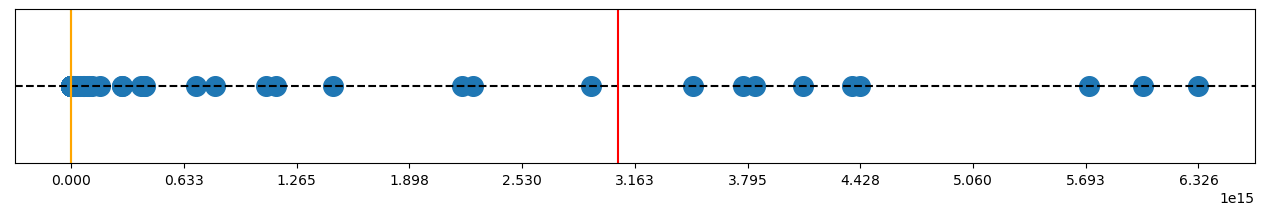

In [145]:
### Valor del contrato
print(secopII_Master['Valor del Contrato'].describe())
print('Tipo de contrato de los 500 valores más altos:\n',
      secopII_Master.nlargest(500, 'Valor del Contrato')['Tipo de Contrato'].value_counts())
print('Tipo de contrato de los 100 valores más altos:\n',
      secopII_Master.nlargest(100, 'Valor del Contrato')['Tipo de Contrato'].value_counts())
print('--Quantiles superiores--')
print(secopII_Master['Valor del Contrato'].quantile([0.95,0.99, 0.995, 0.999, 0.9999]))

print('#obs sobre p95',(secopII_Master['Valor del Contrato'] >secopII_Master['Valor del Contrato'].quantile(0.95)).sum())
print('#obs sobre p99',(secopII_Master['Valor del Contrato'] >secopII_Master['Valor del Contrato'].quantile(0.99)).sum())
print('#obs sobre p99.5',(secopII_Master['Valor del Contrato'] >secopII_Master['Valor del Contrato'].quantile(0.995)).sum())
print('#obs sobre p99.9',(secopII_Master['Valor del Contrato'] >secopII_Master['Valor del Contrato'].quantile(0.999)).sum())
#Gráfica 1d
plt.figure(figsize=(16,2))
plt.axhline(1, c='k', linestyle='--')
plt.scatter(secopII_Master['Valor del Contrato'], np.ones(secopII_Master.shape[0]), s=200)
plt.axvline(secopII_Master['Valor del Contrato'].quantile(0.95), c='y')
plt.axvline(secopII_Master['Valor del Contrato'].quantile(0.999), c='orange')
plt.axvline(secopII_Master['Valor del Contrato'].quantile(0.9999), c='r')
plt.yticks([])
plt.xticks(np.arange(0, secopII_Master['Valor del Contrato'].max()+1000, secopII_Master['Valor del Contrato'].max()/10))
plt.show()

Teniendo en cuenta que estos valores altos corresponden en su mayoría a tipo de contratos para los cuales es ilógica la cifra, de la mano con la gráfica y revisión de percentiles, y el número considerable de observaciones; se excluirá de la muestra las observaciones con valor del contrato mayor al cuantil 0.995 que no sean del tipo "Obra", referente a obras públicas de alto costo.

In [146]:
### Valor del Contrato
q995_vc = secopII_Master['Valor del Contrato'].quantile(0.995)
#Conservar filas con valor inferior al quantil 0.995 o que sean del tipo obras.
secopII_Master = secopII_Master[(secopII_Master['Valor del Contrato'] < q995_vc) |\
                                (secopII_Master['Tipo de Contrato']=='Obra')]

Inspección de los valores de pago adelantado.

count        87123.000
mean       1190638.615
std       66110505.522
min              0.000
25%              0.000
50%              0.000
75%              0.000
max     7287705201.000
Name: Valor de pago adelantado, dtype: float64
#Adelanto mayor a valor del contrato 0


([], <a list of 0 Text major ticklabel objects>)

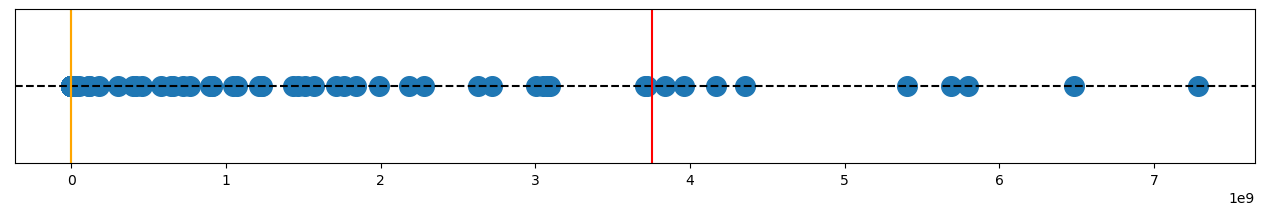

In [147]:
### Valor de pago adelantado
print(secopII_Master['Valor de pago adelantado'].describe())
print('#Adelanto mayor a valor del contrato',
      (secopII_Master['Valor de pago adelantado'] > secopII_Master['Valor del Contrato']).sum() )

plt.figure(figsize=(16,2))
plt.axhline(1, c='k', linestyle='--')
plt.scatter(secopII_Master['Valor de pago adelantado'], np.ones(secopII_Master.shape[0]), s=200)
plt.axvline(secopII_Master['Valor de pago adelantado'].quantile(0.95), c='y')
plt.axvline(secopII_Master['Valor de pago adelantado'].quantile(0.999), c='orange')
plt.axvline(secopII_Master['Valor de pago adelantado'].quantile(0.9999), c='r')
plt.yticks([])

## Con el filtro del valor no hay razones para eliminar observaciones.


In [148]:
### Valor de pago adelantado
## Crear pago adelantado como proporción del valor del contrato.
secopII_Master['Proporcion pagada adelantado'] = secopII_Master['Valor de pago adelantado']/secopII_Master['Valor del Contrato']

## Eliminar valor pagado adelantado para evitar combinación lineal entre columnas.
secopII_Master.drop(columns='Valor de pago adelantado', inplace=True)

Inspección de valores del Saldo CDP

count            87123.000
mean        9325007368.979
std       173808170860.201
min                  0.000
25%                  0.000
50%           23834390.000
75%           95200000.000
max     22007500000000.000
Name: Saldo CDP, dtype: float64
#Saldo menor a valor del contrato 0.33926747242404415
--Quantiles superiores--
0.950     20000000000.000
0.990     67500000000.000
0.995     87602619117.000
0.999   3301100000000.000
1.000   6750000000576.000
Name: Saldo CDP, dtype: float64
#obs sobre p99.9 59


([], <a list of 0 Text major ticklabel objects>)

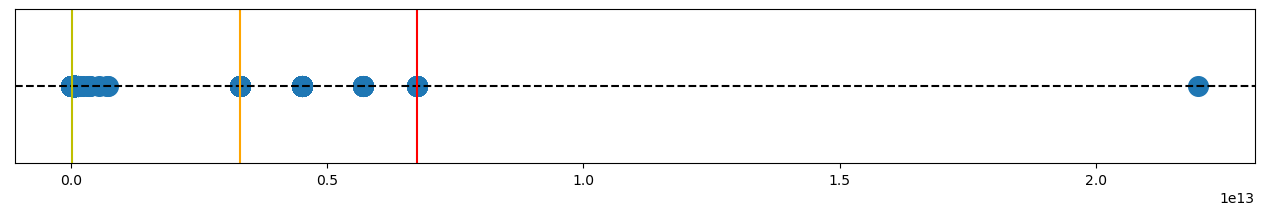

In [149]:
### Saldo CDP
print(secopII_Master['Saldo CDP'].describe() )
print('#Saldo menor a valor del contrato',
      (secopII_Master['Valor del Contrato'] > secopII_Master['Saldo CDP']).sum()/secopII_Master.shape[0] )

print('--Quantiles superiores--')
print(secopII_Master['Saldo CDP'].quantile([0.95,0.99, 0.995, 0.999, 0.9999]))

print('#obs sobre p99.9',(secopII_Master['Saldo CDP'] >secopII_Master['Saldo CDP'].quantile(0.999)).sum())

plt.figure(figsize=(16,2))
plt.axhline(1, c='k', linestyle='--')
plt.scatter(secopII_Master['Saldo CDP'], np.ones(secopII_Master.shape[0]), s=200)
plt.axvline(secopII_Master['Saldo CDP'].quantile(0.95), c='y')
plt.axvline(secopII_Master['Saldo CDP'].quantile(0.999), c='orange')
plt.axvline(secopII_Master['Saldo CDP'].quantile(0.9999), c='r')
plt.yticks([])


Es clara la presencia de valores irregulares, como referencia la SUB RED INTEGRADA DE SERVICIOS DE SALUD DEL SUR tuvo un presupuesto asignado de \$95.434.023.600 para 2021([consultese aquí](https://www.subredsur.gov.co/sites/default/files/presupuesto/RESOLUCI%C3%93N%201595%202020%20APROBACI%C3%93N%20PRESUPUESTO%20INICIAL%20VIGENCIA%202021.pdf)) muy inferior al CDP reportado en los extremos de la distribución para esta entidad. Por esto, se eliminarán las observaciones con valores del Saldo CDP superiores al cuantil 0.999.

In [150]:
### Saldo CDP
q999_CDP = secopII_Master['Saldo CDP'].quantile(0.999)
secopII_Master = secopII_Master[secopII_Master['Saldo CDP'] < q999_CDP] #Conservar valores menores al cuantil 0.999

## CDP como proporción del valor
secopII_Master['Saldo CDP respecto Valor'] = secopII_Master['Saldo CDP']/secopII_Master['Valor del Contrato']

## En caso de 0/0
secopII_Master['Saldo CDP respecto Valor'].fillna(-1, inplace=True)

## En caso de x/0 el contrato es 0 pero hay presupuesto presentado, se llenará con -1 dado que no aplica al no haber valor.
secopII_Master.loc[(secopII_Master['Saldo CDP respecto Valor']==np.inf), 'Saldo CDP respecto Valor'] = 0

Revisión de las transformaciones realizadas a Saldo CDP

In [151]:
print(secopII_Master['Saldo CDP'].describe())
print('#Saldo menor a valor del contrato',
      (secopII_Master['Valor del Contrato'] > secopII_Master['Saldo CDP']).sum()/secopII_Master.shape[0] )
print(secopII_Master['Saldo CDP respecto Valor'].describe())

count           87027.000
mean       4297222896.363
std       49420142000.008
min                 0.000
25%                 0.000
50%          23713632.000
75%          94500000.000
max     3300000000000.000
Name: Saldo CDP, dtype: float64
#Saldo menor a valor del contrato 0.33964172038562745
count        87027.000
mean         76787.164
std       22259075.501
min             -1.000
25%              0.000
50%              1.000
75%              1.214
max     6566250000.000
Name: Saldo CDP respecto Valor, dtype: float64


In [152]:
### EsPostConflicto
secopII_Master['EsPostConflicto'].replace('ND','No',inplace=True)

In [153]:
### Duracion Y unidades de duracion
#Estas se eliminan debido a que ya se tiene la variable con los días entre inicio y fin del contrato.
secopII_Master.drop(columns=['Duracion', 'Unidad de Duracion'], inplace=True)

Los grupos para los segmentos se consiguen teniendo en cuanta el "UNSPSC Classification Guidelines" 2004 página 8.[Enlace](https://unece.org/fileadmin/DAM/trade/agr/meetings/ge.06/2005/2005_i04_UNSPSC.pdf)

In [154]:
### Segment name
#Se convierte a entero de 2 dígitos.
Cseg = (secopII_Master['Codigo Segmento Categoria Principal']/1000000).astype('int64')  #Convertir a entero para comparar                

#Crear categorías de grupos según el documento UNSPSC Classification Guidelines" 2004
secopII_Master['CGrupos'] = ((Cseg>=10) & (Cseg<=15))*1 + ((Cseg>=20) & (Cseg<=27))*2 + ((Cseg>=30) & (Cseg<=41))*3 +\
                            ((Cseg>=42) & (Cseg<=60))*4 + ((Cseg>=64) & (Cseg<=95))*5 + (Cseg==80)*1

#Asignar nombre a las categorías
secopII_Master['CGrupos'] = secopII_Master['CGrupos'].astype(str).replace(['1','2','3','4','5','6'], 
                                                ['Materias primas','Equipo industrial', 'Componentes y suministros de equipos',
                                                'Productos manufacturados','Servicios(No Admin)', 'Servicios administrativos'
                                                ])

del Cseg
#Renombrar variable de grupos
secopII_Master.rename(columns={'CGrupos':'Grupo categoria principal'}, inplace=True)

In [155]:
### Tipo Empresa Proveedor
secopII_Master['Tipo Empresa Proveedor'].unique()
#Diccionario de valores de tipo de empresa a agrupar
dict_te = {'Sociedad Anónima Cerrada Colombiana':'Sociedad Anónima', 'Sociedad Anónima Abierta colombiana':'Sociedad Anónima',
           'Sociedad en Comandita Simple colombiana':'Sociedad en Comandita',
           'Sociedad en Comandita por Acciones colombiana':'Sociedad en Comandita',
           'Fundaciones':'Entidades sin ánimo de lucro', 'Cooperativas':'Entidades sin ánimo de lucro',
           'Otras Entidades públicas':'Otro', 'Promesa de Sociedad Futura':'Otro',
           'Entidad Estatal de acuerdo con la definición del Decreto 1082 de 2015':'Otro',
           'Veeduria Ciudadana':'Otro', 'Patrimonios Autónomos': 'Sociedad Anónima',
           'Persona Jurídica Extranjera sin domicilio en Colombia':'Organismo o Persona Extranjera o Internacional',
           'Sucursal de Sociedad Extranjera':'Organismo o Persona Extranjera o Internacional', 
           'Organismos de Derecho Internacional':'Organismo o Persona Extranjera o Internacional',
           'Organismos Multilaterales de Crédito':'Organismo o Persona Extranjera o Internacional',
           'Personas Extranjeras de Derecho Público':'Organismo o Persona Extranjera o Internacional',
           'Persona Natural Extranjera':'Organismo o Persona Extranjera o Internacional',
           'Unión Temporal':'Consorcio', 'Consórcio':'Consorcio', 'Corporation':'Otro', 'Corporaciones':'Otro',
           'Federaciones':'Otro', 'Institución de Educación Superior':'Otro', 'Asociaciones':'Otro',
           'Empresa unipersonal colombiana':'Otro'
          }
#Reemplazar valores según diccionario.
secopII_Master['Tipo Empresa Proveedor Resumido'] = secopII_Master['Tipo Empresa Proveedor'].replace(dict_te)


Inspección de variables a nivel de portafolio

Valores nulos:
 Proveedores Invitados                 4545
Proveedores con Invitacion Directa    4545
Conteo de Respuestas a Ofertas        4545
Fecha de Publicacion del Proceso      4545
Fecha de Ultima Publicación           4545
Precio Base                           4545
Numero_de_procesos_reportados         4545
dtype: int64


,Proveedores Invitados,Proveedores con Invitacion Directa,Conteo de Respuestas a Ofertas,Precio Base,Numero_de_procesos_reportados
count,82482.000,82482.000,82482.000,82482.000,82482.000
mean,5.602,0.152,0.016,633088794.352,1.034
std,34.463,2.102,0.688,109238307868.647,0.182
min,0.000,0.000,0.000,-397166484.000,1.000
25%,0.000,0.000,0.000,5835154.000,1.000
50%,0.000,0.000,0.000,19500000.000,1.000
75%,0.000,0.000,0.000,52915000.000,1.000
max,1866.000,155.000,153.000,31360000000000.000,3.000


#Precio Base negativo: 74
#Precio Base cero: 8418


,ID Contrato,Nombre Entidad,Sector,Entidad Centralizada,Tipo de Contrato,Modalidad de Contratacion,Justificacion Modalidad de Contratacion,TipoDocProveedor,Es Grupo,Es Pyme,Habilita Pago Adelantado,Liquidación,Obligación Ambiental,Valor del Contrato,Saldo CDP,EsPostConflicto,Destino Gasto,Proveedores Invitados,Proveedores con Invitacion Directa,Conteo de Respuestas a Ofertas,Fecha de Publicacion del Proceso,Fecha de Ultima Publicación,Precio Base,Numero_de_procesos_reportados,Codigo Segmento Categoria Principal,Numero multas SIC proveedor,Valor acumulado multas SIC proveedor,Numero_adiciones_extension,Numero_adiciones_valor,Dias Adicionados,Tuvo_adiciones_valor,Tuvo_adiciones_tiempo,Tuvo_adiciones,Tipo Empresa Proveedor,Dias Inicio-Firma Contrato,Dias Fin-Inicio Contrato,Dias Inicio-Firma Ejecucion,Dias Fin-Inicio Ejecucion,Dias Proveedor Inscrito,Mes Firma Contrato,Proporcion pagada adelantado,Saldo CDP respecto Valor,Grupo categoria principal,Tipo Empresa Proveedor Resumido
825,CO1.PCCNTR.823692,SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E.,Salud y Protección Social,Descentralizada,Prestación de servicios,Contratación régimen especial,Regla aplicable,Cédula de Ciudadanía,No,No,No,No,No,7612850,26265000000.000,No,Funcionamiento,0.000,0.000,0.000,2019-02-11,2019-02-11,-386694000.000,1.000,85000000,0,0.000,0.000,0.000,0,0,0,0,Persona Natural colombiana,-146,180,-146,180,589,Jun,0.000,3450.088,Servicios(No Admin),Persona Natural colombiana
3077,CO1.PCCNTR.823129,SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E.,Salud y Protección Social,Descentralizada,Prestación de servicios,Contratación régimen especial,Regla aplicable,Cédula de Ciudadanía,No,Si,No,No,No,5022000,26265000000.000,No,Funcionamiento,0.000,0.000,0.000,2019-02-11,2019-02-11,-386694000.000,1.000,85000000,0,0.000,0.000,0.000,0,0,0,0,Persona Natural colombiana,-108,88,-108,88,517,May,0.000,5229.988,Servicios(No Admin),Persona Natural colombiana
3640,CO1.PCCNTR.823628,SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E.,Salud y Protección Social,Descentralizada,Prestación de servicios,Contratación régimen especial,Regla aplicable,Cédula de Ciudadanía,No,No,No,No,No,5022000,26265000000.000,No,Funcionamiento,0.000,0.000,0.000,2019-02-11,2019-02-11,-386694000.000,1.000,85000000,0,0.000,0.000,0.000,0,0,0,0,Persona Natural colombiana,-108,88,-105,85,549,May,0.000,5229.988,Servicios(No Admin),Persona Natural colombiana
6662,CO1.PCCNTR.826208,SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E.,Salud y Protección Social,Descentralizada,Prestación de servicios,Contratación régimen especial,Regla aplicable,Cédula de Ciudadanía,No,No,No,No,No,7612850,26265000000.000,No,Funcionamiento,0.000,0.000,0.000,2019-02-11,2019-02-11,-386694000.000,1.000,85000000,0,0.000,0.000,0.000,0,0,0,0,Persona Natural colombiana,-146,180,-146,180,588,Jun,0.000,3450.088,Servicios(No Admin),Persona Natural colombiana
11367,CO1.PCCNTR.824663,SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E.,Salud y Protección Social,Descentralizada,Prestación de servicios,Contratación régimen especial,Regla aplicable,Cédula de Ciudadanía,No,No,No,No,No,5022000,26265000000.000,No,Funcionamiento,0.000,0.000,0.000,2019-02-11,2019-02-11,-386694000.000,1.000,85000000,0,0.000,0.000,0.000,0,0,0,0,Persona Natural colombiana,-108,88,-108,88,551,May,0.000,5229.988,Servicios(No Admin),Persona Natural colombiana


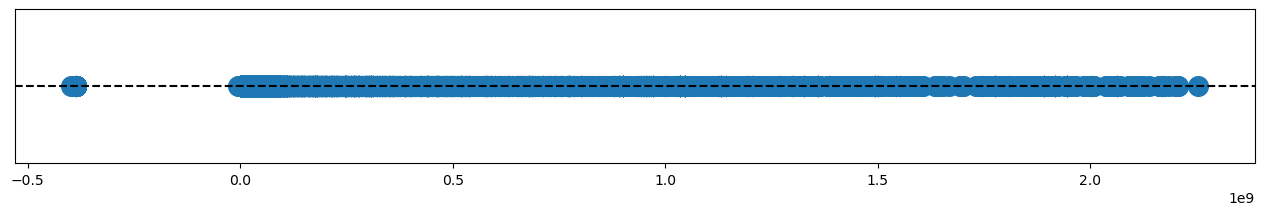

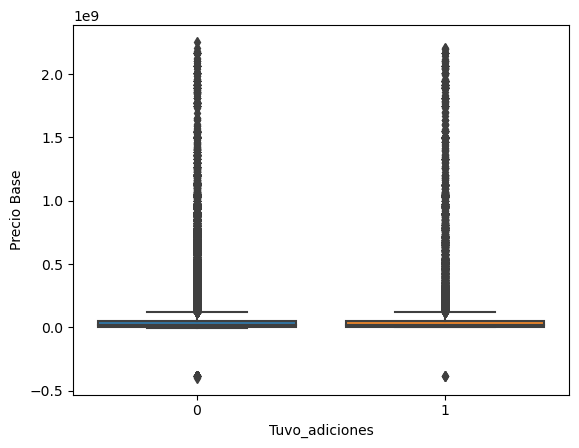

In [156]:
### Variables a nivel de portafolio
var_port = ['Proveedores Invitados', 'Proveedores con Invitacion Directa', 'Conteo de Respuestas a Ofertas',
            'Fecha de Publicacion del Proceso', 'Fecha de Ultima Publicación', 'Precio Base',
            'Numero_de_procesos_reportados']
print('Valores nulos:\n', secopII_Master[var_port].isnull().sum() )
display(secopII_Master[var_port].describe())

## No se ven problemas con 'Proveedores Invitados', 'Proveedores con Invitacion Directa', 'Conteo de Respuestas a Ofertas' y
##'Numero_de_procesos_reportados'
## ¿Qué es un precio base negativo? Precio base es el valor proyectado del proceso de compra, incluyendo varios contratos.
print('#Precio Base negativo:', (secopII_Master['Precio Base'] < 0).sum() )
print('#Precio Base cero:', (secopII_Master['Precio Base'] == 0).sum() )
display(secopII_Master[secopII_Master['Precio Base'] < 0].head())

#Gráfica 1-D
q99 = secopII_Master['Precio Base'].quantile(0.99)
X = secopII_Master.loc[secopII_Master['Precio Base']<q99,'Precio Base']

plt.figure(figsize=(16,2))
plt.axhline(1, c='k', linestyle='--')
plt.scatter(X, np.ones(X.shape[0]), s=200)
plt.yticks([])
plt.show()

plt.figure()
sns.boxplot( x=secopII_Master['Tuvo_adiciones'], y=X)
plt.show()

##La variable de precio base contiene inconsestencias que no se pueden solucionar con la información que se tiene y no
## vale la pena eliminar más observaciones por los valores negativos y percentil 1% superior. Además, a simple vista no 
## muestra una relación con la variable respuesta.

In [157]:
### Variables a nivel de portafolio.
## Crear dummie para filtrar fácilmente los datos para portafolio
secopII_Master['Tiene_variables_portafolio'] = 1*(~secopII_Master['Fecha de Publicacion del Proceso'].isnull())
secopII_Master.drop(columns='Precio Base', inplace=True)  #Eliminar precio base por los diversos problemas en el reporte.

In [158]:
### Variables a nivel de portafolio, fechas
#Dar formato de fechas
for var in ['Fecha de Publicacion del Proceso', 'Fecha de Ultima Publicación']:
    secopII_Master[var] = pd.to_datetime(secopII_Master[var])

#Crear duración del proceso en días
secopII_Master['Dias Proceso Contratacion Abierto'] = (secopII_Master['Fecha de Ultima Publicación'] - \
                                                       secopII_Master['Fecha de Publicacion del Proceso'] ).dt.days
#Dar valor de 0 a negativos, -1
secopII_Master.loc[secopII_Master['Dias Proceso Contratacion Abierto']<0, 'Dias Proceso Contratacion Abierto'] = 0

#Mes en que es abierto el proceso
secopII_Master['Mes de Publicacion del Proceso'] = secopII_Master['Fecha de Publicacion del Proceso'].\
                                                    dt.month.astype(str).\
                                                    replace(['1.0','2.0','3.0','4.0','5.0','6.0','7.0','8.0','9.0','10.0','11.0','12.0'],
                                                            ['Ene','Feb','Mar','Abr','May','Jun','Jul','Ago','Sep','Oct','Nov','Dic']
                                                           )

Revisión de las variables creadas en la celda anterior.

,Fecha de Publicacion del Proceso,Fecha de Ultima Publicación
min,2016-04-28,2016-05-17
max,2020-08-25,2020-08-25


#Días 0: 79687


count   82482.000
mean        0.592
std         3.964
min         0.000
25%         0.000
50%         0.000
75%         0.000
max       300.000
Name: Dias Proceso Contratacion Abierto, dtype: float64

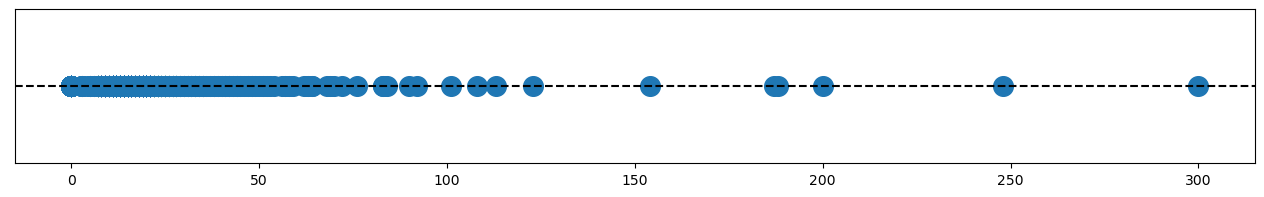

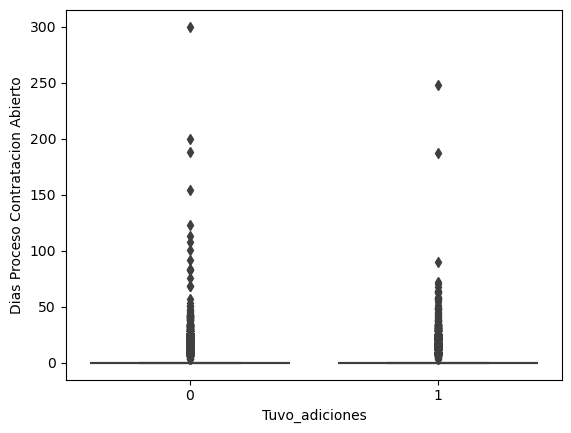

In [159]:
### Variables a nivel de portafolio, fechas    
display(secopII_Master[['Fecha de Publicacion del Proceso', 'Fecha de Ultima Publicación']].agg(['min','max']))

print('#Días 0:', (secopII_Master['Dias Proceso Contratacion Abierto']==0).sum() )

display(secopII_Master['Dias Proceso Contratacion Abierto'].describe())

plt.figure(figsize=(16,2))
plt.axhline(1, c='k', linestyle='--')
plt.scatter(secopII_Master['Dias Proceso Contratacion Abierto'], np.ones(secopII_Master.shape[0]), s=200)
plt.yticks([])
plt.show()

plt.figure()
sns.boxplot( x=secopII_Master['Tuvo_adiciones'], y=secopII_Master['Dias Proceso Contratacion Abierto'])
plt.show()


In [160]:
### Eliminar fechas
secopII_Master.drop(columns=['Fecha de Publicacion del Proceso', 'Fecha de Ultima Publicación'], inplace=True)

In [161]:
### Conservar solo las variables respuesta binarias.
secopII_Master.drop(columns=['Dias Adicionados','Numero_adiciones_extension', 'Numero_adiciones_valor'], inplace=True)

Tras los procedimientos previos se define la base SECOPII_Master a ser usada en el entrenamiento de modelos y análisis exploratorio.

### Guardar datos a usar para EDA y Modelos
A continuación se define el orden de las variables para que las de respuesta queden al final y se exporta como documento csv la base de datos SECOPII_Master.

In [162]:
#Enviar variables respuesta al final
colnames = secopII_Master.columns.to_list()
temp =  colnames[-17:-14]
del colnames[-17:-14]
secopII_Master = secopII_Master[colnames + temp]

In [163]:
## Version 2, se incluyen nuevas variables y las de portafolio con la variable 'Tiene_variables_portafolio' como filtro.
secopII_Master.to_csv('created_data\SECOPII_Master_2.csv', index=False)

## Revisión de entidades
Se contrastan las entidades contenidas con aquellas usadas por Santiago Rodriguez en el siguiente [enlace](https://github.com/SantiagoRodriguezArevalo/BogotaProcurement/blob/main/Data_Prep.ipynb)

In [164]:
l_entidades = ['SECRETARIA DISTRITAL DE INTEGRACION SOCIAL', 'SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E..', 
              'SUBRED INTEGRADA DE SERVICIOS DE SALUD CENTRO ORIENTE E.S.E', 'INSTITUTO DISTRITAL DE LAS ARTES',
              'SECRETARIA DE EDUCACION DEL DISTRITO', 'SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR E.S.E',
              'EMPRESA DE ACUEDUCTO Y ALCANTARILLADO DE BOGOTÁ - E.S.P.', 'SECRETARIA DISTRITAL DE MOVILIDAD',
              'EMPRESA DE TRANSPORTE DEL TERCER MILENIO TRANSMILENIO S. A.',
              'UNIDAD ADMINISTRATIVA ESPECIAL CUERPO OFICIAL DE BOMBEROS DE BOGOTA',
              'SUBRED INTEGRADA DE SERVICIOS DE SALUD SUR OCCIDENTE ESE.', 'PERSONERIA DE BOGOTA',
              'INSTITUTO DISTRITAL PARA LA PROTECCIÓN DE LA NIÑEZ Y LA JUVENTUD', 'SECRETARIA DISTRITAL DE GOBIERNO',
              'SECRETARIA DISTRITAL DE AMBIENTE', 'ALCALDIA LOCAL DE SUBA', 
              'ENTIDAD ASESORA DE GESTION ADMINISTRATIVA Y TECNICA', 'FONDO FINANCIERO DISTRITAL DE SALUD', 
              'SECRETARIA DISTRITAL DEL HABITAT', 'INSTITUTO DE DESARROLLO URBANO', 'JARDÍN BOTÁNICO JOSÉ CELESTINO MUTIS',
              'INSTITUTO DISTRITAL DE RECREACIÓN Y DEPORTE', 'SECRETARÍA GENERAL DE LA ALCALDÍA MAYOR DE BOGOTÁ',
              'INSTITUTO DISTRITAL DE LA PARTICIPACIÓN Y ACCIÓN COMUNAL', 'SECRETARIA DISTRITAL DE PLANEACION',
              'CAJA DE LA VIVIENDA POPULAR', 'UNIDAD ADMINISTRATIVA ESPECIAL DE REHABILITACIÓN Y MANTENIMIENTO VIAL',
              'SECRETARIA DISTRITAL DE LA MUJER', 'INSTITUTO DISTRITAL DE PATRIMONIO CULTURAL', 'ALCALDIA LOCAL DE KENNEDY',
              'ALCALDIA LOCAL DE SAN CRISTOBAL', 'ALCALDIA LOCAL DE CIUDAD BOLIVAR', 'CONTRALORIA DE BOGOTA',
              'ALCALDÍA LOCAL DE ENGATIVÁ', 'UNIDAD ADMINISTRATIVA ESPECIAL DE SERVICIOS PÚBLICOS',
              'ORQUESTA FILARMONICA DE BOGOTA', 'INSTITUTO DISTRITAL DE GESTION DE RIESGOS Y CAMBIO CLIMATICO',
              'ALCALDIA LOCAL DE USME','ALCALDIA LOCAL DE BOSA', 'SECRETARÍA DISTRITAL DE CULTURA, RECREACIÓN Y DEPORTE',
              'EMPRESA DE RENOVACION Y DESARROLLO URBANO DE BOGOTA D.C', 
              'DEPARTAMENTO ADMINISTRATIVO DE LA DEFENSORIA DEL ESPACIO PUBLICO',
              'UNIDAD ADMINISTRATIVA ESPECIAL DE CATASTRO DISTRITAL', 'ALCALDIA LOCAL DE USAQUEN', 
              'SECRETARIA DISTRITAL DE DESARROLLO ECONOMICO', 'ALCALDIA LOCAL RAFAEL URIBE URIBE', 
              'FONDO DE VIGILANCIA Y SEGURIDAD DE BOGOTÁ D.C EN LIQUIDACIÓN',
              'ALCALDIA LOCAL DE FONTIBON', 'ALCALDIA LOCAL DE PUENTE ARANDA-FONDO DE DESARROLLO LOCAL',
              'ALCALDIA LOCAL DE MARTIRES', 'SECRETARIA DISTRITAL DE HACIENDA', 'ALCALDIA LOCAL DE TUNJUELITO',
              'FONDO DE PRESTACIONES ECONOMICAS CESANTIAS Y PENSIONES', 'ALCALDIA LOCAL DE TEUSAQUILLO (oficial)',
              'ALCALDIA LOCAL DE SUMAPAZ', 'ALCALDIA LOCAL DE SANTAFE- FONDO DE DESARROLLO LOCAL DE SANTA FE',
              'ALCALDÍA LOCAL DE CHAPINERO - FONDO DE DESARROLLO LOCAL', 'ALCALDÍA LOCAL DE BARRIOS UNIDOS',
              'ALCALDIA LOCAL DE ANTONIO NARIÑO', 'METRO DE BOGOTA SA', 'FUNDACION GILBERTO ALZATE AVENDAÑO',
              'SECRETARIA JURIDICA DISTRITAL', 'TERMINAL DE TRANSPORTE S.A',
              'INSTITUTO DISTRITAL DE PROTECCION Y BIENESTAR ANIMAL', 'SECRETARIA DE PLANEACION', 'VEEDURIA DISTRITAL',
              'FONDO DE DESARROLLO LOCAL DE LA CANDELARIA',
              'INSTITUTO PARA LA INVESTIGACIÓN EDUCATIVA Y EL DESARROLLO PEDAGÓGICO - IDEP', 'LOTERIA DE BOGOTA',
              'INSTITUTO DISTRITAL DE TURISMO', 'DEPARTAMENTO ADMINISTRATIVO DEL SERVICIO CIVIL DISTRITAL',
              'SECRETARIA DISTRITAL DE SALUD', 'SECRETARÍA DISTRITAL DE CULTURA  RECREACIÓN Y DEPORTE',
              'SECRETARÍA DISTRITAL DE MOVILIDAD'
             ]

In [165]:
entidades2 = pd.read_csv('created_data\secop_II_EntidadesBogota.csv')

In [166]:
e1 = set(l_entidades)
e2 = set(entidades2['Nombre Entidad'].values)

In [167]:
e1-e2

{'ALCALDIA LOCAL DE TEUSAQUILLO (oficial)',
 'ALCALDÍA LOCAL DE ENGATIVÁ',
 'ENTIDAD ASESORA DE GESTION ADMINISTRATIVA Y TECNICA',
 'FONDO FINANCIERO DISTRITAL DE SALUD',
 'INSTITUTO DISTRITAL DE GESTION DE RIESGOS Y CAMBIO CLIMATICO',
 'INSTITUTO DISTRITAL PARA LA PROTECCIÓN DE LA NIÑEZ Y LA JUVENTUD',
 'SECRETARIA DISTRITAL DE INTEGRACION SOCIAL',
 'SECRETARIA DISTRITAL DE MOVILIDAD',
 'SECRETARIA DISTRITAL DE SALUD',
 'SECRETARÍA DISTRITAL DE CULTURA, RECREACIÓN Y DEPORTE',
 'SUBRED INTEGRADA DE SERVICIOS DE SALUD NORTE E.S.E..'}